# <font color='brown'><b>Dissertation project by Jerin Antony on "Effects of dataset characteristics on the performance of SafeML"<b><font>

## Project setup/environment details (versions)
- Python 3.8.9
- scikit-learn 1.1.1 (numpy 1.22.4, scipy 1.8.1, threadpoolctl 3.1.0)
- pandas 1.4.2 (python-dateutil 2.8.2, six 1.16.0)
- scikit-plot 0.3.7 (packaging 21.3, pyparsing 3.0.9, fonttools 4.33.3)
- seaborn 0.11.2 (matplotlib 3.5.2)
- scikit-dimension 0.3
- numba 0.53.0
- Windows10 Home 64bit
- Jupyter notebook 6.4.5

### Installing the python packages
Type below commands in console to install packages
- pip install pandas
- pip install scikit-learn
- pip install scikit-plot
- pip install seaborn
- pip install scikit-dimension
- pip install numba==0.53 (to resolve the scikit-dimension issue. Refer https://stackoverflow.com/questions/70148065/numba-needs-numpy-1-20-or-less-for-shapley-import)
- pip install pingouin
- pip install graphviz

## References
__Jupyter notebook markdown help__
https://medium.com/analytics-vidhya/the-jupyter-notebook-formatting-guide-873ab39f765e
    

### Project configuration data (Global environment variables)
Below variables are configurable for the project
- safeMLpath : Path where distance measure code is present from safeML
- datasetsPath : Path where datasets files are stored
- testDatasetName : name of the dataset file in .csv format used for testing
- pcaDimensions : dimension for PCA calculation
- stratifiedKfoldSplits : number of splits for statified Kfold method for spliting dataset for train and test

In [1]:
safeMLpath = './SafeML/Implementation_in_Python/'
datasetsPath = './Datasets/'
testDatasetName = 'data_banknote_authentication.csv'
testDataset1Name = 'diabetes.csv'# 0's
testDataset2Name = 'nba_logreg.csv' #NaN
testDataset3Name = 'heart.csv' #NaN
className = 'output'#'TARGET_5Yrs'#'Outcome'#'class'
pcaDimensions = 7
stratifiedKfoldSplits = 10
estimators4RandomForest = 1000

### Importing the python packages
following installed packages are imported here:
- pandas
- matplotlib

Also, following local files part of SafeML distance measures are imported:
- CVM_Dist
- Anderson_Darling_Dist
- Kolmogorov_Smirnov_Dist
- Kuiper_Dist
- Wasserstein_Dist
- DTS_Dist

In [2]:
%matplotlib inline
#importing necessay packages to the project
import pandas as pd #for DataFrames, Series, and reading csv data in.
import matplotlib.pyplot as plt #MatPlotLib for plotting data visually.
import seaborn as sns #for plotting graphs, built on top of MatPlot.
import numpy as np #for array manipulation
import skdim #for instrisic dimensionality calculation of a dataset
from pingouin import multivariate_normality #for multivariate normality test
import time #for timing calculations

from sklearn.metrics import classification_report, confusion_matrix #for confusion matrix and calculation of classification params
from sklearn.decomposition import PCA #for dimensionality reduction of a dataset using PCA
from sklearn.preprocessing import StandardScaler #for scaling data into unit scale
from sklearn.model_selection import StratifiedKFold #for splitting the dataset for train and test using stratified Kfold method
from sklearn.ensemble import RandomForestClassifier #for random forest classifier
from sklearn.metrics import accuracy_score #for calculating accuracy of model predictions
from sklearn.metrics.cluster import homogeneity_score #for homogeneity calculations
from sklearn.tree import DecisionTreeClassifier #for decision tree classifier
from sklearn import tree #for decision tree plot for analysing final results

# Importing the local modules for statistical distance measures in SafeML
import sys
if safeMLpath not in sys.path:#adding the safeML code path to system path if not present
    sys.path.append(safeMLpath)
from WassersteinDistance import Wasserstein_Dist
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from DTS_Distance import DTS_Dist # Combination of Anderson_Darling and CVM distance measures.

import glob #for file and directory read operations

## Defined functions and wrappers
Following functions/wrappers are defined for easy handling of datasets:

<a id='FunctionsList'>FunctionsList</a>
- [readDataset2DataFrame(datasetFullPathInCSVformat)](#readDataset2DataFrame)
- [fixDatasetColumnName(datasetInDataFrameFormat)](#readDataset2DataFrame)
- [displayConfusionMatrixHeatMap(actualValuesXaxis, predictedValuesYaxis)](#displayConfusionMatrixHeatMap)
- [displayClassificationReport(actualValuesXaxis, predictedValuesYaxis)](#displayClassificationReport)
- [displayCorrelationMatrixHeatMap(datasetInDataFrameFormat)](#displayCorrelationMatrixHeatMap)
- [getDatasetDimensionality(datasetInDataFrameFormat)](#getDatasetDimensionality)
- [getDatasetNumberOfInstances(datasetInDataFrameFormat)](#getDatasetNumberOfInstances)
- [getDatasetNumberOfClasses(datasetInDataFrameFormat, className)](#getDatasetNumberOfClasses)
- [getNumberOfZerosInDataset(df_Dataset)](#getNumberOfZerosInDataset)
- [getNumberOfNaNsInDataset(df_Dataset)](#getNumberOfNaNsInDataset)
- [getNumberOfZerosInAdatasetFeature(df_Dataset, featureName)](#getNumberOfZerosInAdatasetFeature)
- [getNumberOfNaNsInAdatasetFeature(df_Dataset, featureName)](#getNumberOfNaNsInAdatasetFeature)
- [getZeroSparsity(df_Dataset)](#getZeroSparsity)
- [getNaNSparsity(df_Dataset)](#getNaNSparsity)
- [getDataSparsity(df_Dataset, className)](#getDataSparsity)
- [getFeatureNoise(df_DatasetFeatures)](#getFeatureNoise)
- [getIntrinsicDimensionaltiy(df_DatasetFeatures)](#getIntrinsicDimensionaltiy)
- [getIntrinsicDimensionaltiyRatio(df_DatasetFeatures)](#getIntrinsicDimensionaltiyRatio)
- [getFeatureNoise2(df_DatasetFeatures)](#getFeatureNoise2)
- [getCorrelationOfFeaturesWithNoClass(df_Dataset, className)](#getCorrelationOfFeaturesWithNoClass)
- [getCorrelationOfFeaturesWithClass(df_Dataset, className)](#getCorrelationOfFeaturesWithClass)
- [getMultiVariateNormality(df_DatasetFeatures)](#getMultiVariateNormality)
- [isMultiVariateNormalityExists(df_DatasetFeatures)](#isMultiVariateNormalityExists)
- [getAllCovarianceOfFeatures(df_Dataset, className)](#getAllCovarianceOfFeatures)
- [getHomogeneityOfClassCovariance(df_Dataset, className)](#getHomogeneityOfClassCovariance)
- [reduceDimensionsUsingPCA(datasetInDataFrameFormat, NumOfPCAcomponents)](#reduceDimensionsUsingPCA)
- [scaleDatasetUsingStandardScalar(datasetInDataFrameFormat)](#scaleDatasetUsingStandardScalar)
- [getSplitTrainNtestDataUsingStratKfold(InputX, OutputY, folds=10)](#getSplitTrainNtestDataUsingStratKfold)
- [getRFpossibleAccuraciesWithStatSplit(InputX, OutputY, numberOfSplits, estimators=200)](#getRFpossibleAccuraciesWithStatSplit)
- [getRandomForestModelForDataset(X_train, Y_train, estimators=100)](#getRandomForestModelForDataset)
- [getPredictedValuesNaccuracy(model, X_Test, expected_y)](#getPredictedValuesNaccuracy)
- [displayMultivariateAnalysisPlot(datasetInDataFrameFormat, classColName, NumberOfColumns)](#displayMultivariateAnalysisPlot)
- [getAllStatDistMeasureForAclassTrainNtestInputs(X_trainForAclass, X_testForAclass)](#getAllStatDistMeasureForAclassTrainNtestInputs)
- [getTrainNtestFeatures4APredictedLabel(df_X_train, df_X_test, df_Y_train, df_Y_predicted, label)](#getTrainNtestFeatures4APredictedLabel)
- [getAccuracyNdistMeasures4allFolds(df_Dataset, className, label)](#getAccuracyNdistMeasures4allFolds)
- [displayScatterPlot4AllDistsNAccuracies(df_DistsNAccuracies, labelName)](#displayScatterPlot4AllDistsNAccuracies)
- [getPearsonCorrValues4allDistsNAccuracies(df_DistsNAccuracies)](#getPearsonCorrValues4allDistsNAccuracies)
- [getBestDistanceMeasureForDataset(lst_df_DistsNAccuraciesClass, method='min_mean')](#getBestDistanceMeasureForDataset)
- [populateDatasetCharaNdistMeasureTable(datasetsPath)](#populateDatasetCharaNdistMeasureTable)
- [saveDataframeToCSV(df_Data, filePath2Save)](#saveDataframeToCSV)
- [def drawNSaveDecisionTree(df_Dataset, className, savePath)](#drawNSaveDecisionTree)

[Goto Main Code Start](#MainCode)

[Click here to go to FunctionsList](#FunctionsList)
### <a id='readDataset2DataFrame'>Function Name: readDataset2DataFrame()</a>
__Description:__ 
To read the dataset in .csv format and return the dataset in pandas dataframe

__Inputs:__
1. datasetFullPathInCSVformat: full path of the dataset to be read in csv format

__Return:__
1. dataset in pandas dataframe format


In [3]:
def readDataset2DataFrame(datasetFullPathInCSVformat):
    return pd.read_csv(datasetFullPathInCSVformat)

#uncomment the test code below for testing
df = readDataset2DataFrame(datasetsPath+testDatasetName)
df.head()

variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='fixDatasetColumnName'>Function Name: fixDatasetColumnName()</a>
__Description:__ 
To fix the dataset colum name in the dataframe. It strips the spaces in the begining and end, replaces the spaces with '_', 
converts the upper case to lower cases and replaces the braces. Doing so will help for searching in dataframe.

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format

__Return:__
1. dataset in pandas dataframe format with colum name corrected

In [4]:
def fixDatasetColumnName(datasetInDataFrameFormat):
    datasetInDataFrameFormat.columns = datasetInDataFrameFormat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    #print(datasetInDataFrameFormat.columns)
    return datasetInDataFrameFormat

#uncomment the test code below for testing
df = fixDatasetColumnName(df)
df.head()

variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='displayConfusionMatrixHeatMap'>Function Name: displayConfusionMatrixHeatMap()</a>
__Description:__ 
To plot the confustion matrix as heatmap with the actual and predicted values (see https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5)

__Inputs:__
1. actualValuesXaxis: array of actual values/labels to plot on X axis
1. actualValuesYaxis: array of predicted values/labels to plot on Y axis

__Return:__
1. confusion matrix plotted as heatmap

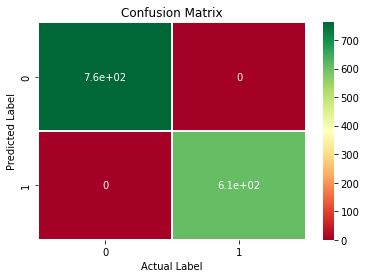

In [5]:
def displayConfusionMatrixHeatMap(actualValuesXaxis, predictedValuesYaxis):
    cm_matrix = confusion_matrix(actualValuesXaxis, predictedValuesYaxis)
    # Displaying dataframe, cm_matrix as an heatmap with diverging colourmap as RdYlGn
    sns.heatmap(cm_matrix, cmap ='RdYlGn', linewidths = 0.30, annot = True)
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

#uncomment the test code below for testing
displayConfusionMatrixHeatMap(df['class'], df['class'])
    

[Click here to go to FunctionsList](#FunctionsList)
### <a id='displayClassificationReport'>Function Name: displayClassificationReport()</a>
__Description:__ 
To display the classification report for the actual and predicted values/labels (see https://gist.github.com/fclesio/bb5871281debc07d75127552c56b08b5)

__Inputs:__
1. actualValuesXaxis: array of actual values/labels
1. actualValuesYaxis: array of predicted values/labels

__Return:__
1. classification report in pandas dataframe report

In [6]:
def displayClassificationReport(actualValuesXaxis, predictedValuesYaxis):
    report = classification_report(actualValuesXaxis, predictedValuesYaxis, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df.sort_values(by=['f1-score'], ascending=False)
    return df

#uncomment the test code below for testing
displayClassificationReport(df['class'], df['class'])

precision  recall  f1-score  support
0                   1.0     1.0       1.0    762.0
1                   1.0     1.0       1.0    610.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1372.0
weighted avg        1.0     1.0       1.0   1372.0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='displayCorrelationMatrixHeatMap'>Function Name: displayCorrelationMatrixHeatMap()</a>
__Description:__ 
To plot the correlation matrix as heatmap for the features in a dataset (see https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/). This helps to identify the correlation between each features.

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format

__Return:__
1. correlation matrix for the features plotted as heatmap

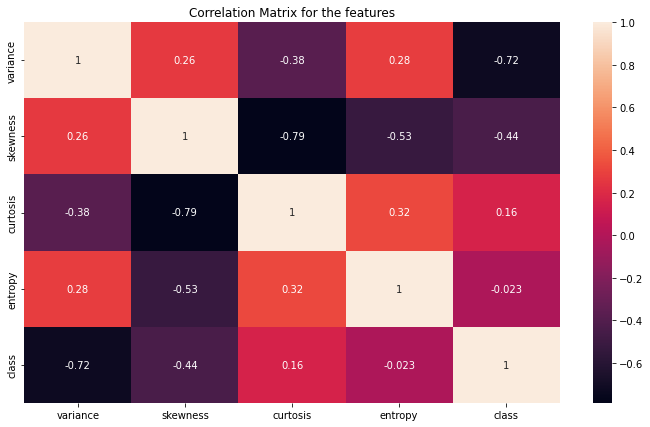

In [7]:
def displayCorrelationMatrixHeatMap(datasetInDataFrameFormat):
    # Defining figure size for the output plot in inches
    fig, ax = plt.subplots(figsize = (12, 7))
    df = pd.DataFrame(datasetInDataFrameFormat, columns =datasetInDataFrameFormat.columns)
    corr = df.corr()
    plt.title('Correlation Matrix for the features')
    sns.heatmap(corr, annot = True)

#uncomment the test code below for testing
displayCorrelationMatrixHeatMap(df)

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getDatasetDimensionality'>Function Name: getDatasetDimensionality()</a>
__Description:__ 
To get the dimensionality (number of features/attributes present in a dataset) of a dataset passed as dataframe in pandas format.
Note: Class/Label colum is not considers as a feature here

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format

__Return:__
1. dimentionality-number of features present in the dataset

In [8]:
def getDatasetDimensionality(datasetInDataFrameFormat):
    #number of columns ignoring the class column
    return datasetInDataFrameFormat.shape[1] - 1

#uncommment below code for tesing
getDatasetDimensionality(df)


4

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getDatasetNumberOfInstances'>Function Name: getDatasetNumberOfInstances()</a>
__Description:__ 
To get the number of instances present in a dataset passed as dataframe in pandas format.

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format

__Return:__
1. number of instances present in a dataset

In [9]:
def getDatasetNumberOfInstances(datasetInDataFrameFormat):
    return datasetInDataFrameFormat.shape[0]

#uncommment below code for tesing
getDatasetNumberOfInstances(df)

1372

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getDatasetNumberOfClasses'>Function Name: getDatasetNumberOfClasses()</a>
__Description:__ 
To get the number of classes present in a dataset for a class.

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format
2. className: colum name where classes/Labels are present

__Return:__
1. number of classes present in a dataset for the given Label

In [10]:
def getDatasetNumberOfClasses(datasetInDataFrameFormat, className):
    return len(datasetInDataFrameFormat[className].unique())
    
#uncommment below code for tesing
getDatasetNumberOfClasses(df, 'class')

2

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getNumberOfZerosInDataset'>Function Name: getNumberOfZerosInDataset()</a>
__Description:__ 
To get the number of zeros present in a dataset (code reference https://stackoverflow.com/questions/59886916/how-to-find-number-of-zeros-in-a-pandas-dataframe).

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format

__Return:__
1. number of zeros present in a dataset for all the features

In [11]:
def getNumberOfZerosInDataset(df_Dataset):
    return (df_Dataset==0).sum().sum()

#uncommment below code for tesing
getNumberOfZerosInDataset(df)

762

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getNumberOfNaNsInDataset'>Function Name: getNumberOfNaNsInDataset()</a>
__Description:__ 
To get the number of NaN (null values) present in a dataset (code reference https://stackoverflow.com/questions/59886916/how-to-find-number-of-zeros-in-a-pandas-dataframe).

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format

__Return:__
1. number of NaNs present in a dataset for all the features

In [12]:
def getNumberOfNaNsInDataset(df_Dataset):
    return df_Dataset.isnull().sum().sum()

#uncommment below code for tesing
getNumberOfNaNsInDataset(df)

0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getNumberOfZerosInAdatasetFeature'>Function Name: getNumberOfZerosInAdatasetFeature()</a>
__Description:__ 
To get the number of zeros present in a dataset for a given feature column(code reference https://stackoverflow.com/questions/59886916/how-to-find-number-of-zeros-in-a-pandas-dataframe).

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format

__Return:__
1. number of zeros present in a dataset for a given feature

In [13]:
def getNumberOfZerosInAdatasetFeature(df_Dataset, featureName):
    arr = (df_Dataset==0).sum()[featureName]
    return arr
#uncommment below code for tesing
getNumberOfZerosInAdatasetFeature(df, 'variance')

0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getNumberOfNaNsInAdatasetFeature'>Function Name: getNumberOfNaNsInAdatasetFeature()</a>
__Description:__ 
To get the number of NaNs present in a dataset for a given feature column(code reference https://stackoverflow.com/questions/59886916/how-to-find-number-of-zeros-in-a-pandas-dataframe).

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format

__Return:__
1. number of NaNs present in a dataset for a given feature

In [14]:
def getNumberOfNaNsInAdatasetFeature(df_Dataset, featureName):
    return df_Dataset[featureName].isnull().sum()
    
#uncommment below code for tesing
getNumberOfNaNsInAdatasetFeature(df, 'variance')

0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getZeroSparsity'>Function Name: getZeroSparsity()</a>
__Description:__ 
To get the zero sparsity measure. number of zeros present in a dataset divided by total number of entries present in a dataset

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format

__Return:__
1. zero sparsity in fraction and not in percentage

In [15]:
def getZeroSparsity(df_Dataset):
    return getNumberOfZerosInDataset(df)/df_Dataset.count().sum()

#uncommment below code for tesing
getZeroSparsity(df)

0.11107871720116617

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getNaNSparsity'>Function Name: getNaNSparsity()</a>
__Description:__ 
To get the NaN sparsity measure. number of NaNs present in a dataset divided by total number of entries present in a dataset

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format

__Return:__
1. NaN sparsity in fraction and not in percentage

In [16]:
def getNaNSparsity(df_Dataset):
    return getNumberOfNaNsInDataset(df)/df_Dataset.count().sum()

#uncommment below code for tesing
getNaNSparsity(df)

0.0

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getDataSparsity'>Function Name: getDataSparsity()</a>
__Description:__ 
To get the data sparsity as per the published paper. DataSparsity = pow(N,1/d)

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format
2. className : name of the class column in the dataset

__Return:__
1. calculated data sparsity

In [17]:
def getDataSparsity(df_Dataset, className):
    N = getDatasetNumberOfClasses(df_Dataset, className)
    d = getDatasetDimensionality(df_Dataset)
    #print(N, d)
    return N ** (1/d)

#uncommment below code for tesing
print (getDataSparsity(df, 'class'))

1.189207115002721


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getFeatureNoise'>Function Name: getFeatureNoise()</a>
__Description:__ 
To calculate the feature noise (feature noise here is defined as average of all the variance of feature columns)

__Inputs:__
1. df_DatasetFeatures: dataset features in pandas dataframe format without class column

__Return:__
1. feature noise (average of variances of features)

In [18]:
def getFeatureNoise(df_DatasetFeatures):
    sumVariance = 0
    count = df_DatasetFeatures.shape[1]
    for (colName, colData) in df_DatasetFeatures.iteritems():
        sumVariance = sumVariance + colData.var()
        #print('Column Name : ', colData)
        #print('Column Contents : ', colData.values)
    return sumVariance/count

#uncommment below code for tesing
print (getFeatureNoise(df))    

13.152947208754364


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getIntrinsicDimensionaltiy'>Function Name: getIntrinsicDimensionaltiy()</a>
__Description:__ 
Function to calculate the Intrinsic Dimensionality (ID) based on PCA. (Reference code: https://scikit-dimension.readthedocs.io/en/latest/basics.html)

__Inputs:__
1. df_DatasetFeatures: dataset features in pandas dataframe format without class column

__Return:__
1. intrinsic dimensionality

In [19]:
def getIntrinsicDimensionaltiy(df_DatasetFeatures):
    pca = skdim.id.lPCA().fit(df_DatasetFeatures)
    return pca.dimension_

#uncommment below code for tesing
print (getIntrinsicDimensionaltiy(df.drop('class',axis=1)))

3


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getIntrinsicDimensionaltiyRatio'>Function Name: getIntrinsicDimensionaltiyRatio()</a>
__Description:__ 
Function to calculate the Intrinsic Dimensionality (ID) based on PCA

__Inputs:__
1. df_DatasetFeatures: dataset features in pandas dataframe format without class column

__Return:__
1. intrinsic dimensionality ratio

In [20]:
def getIntrinsicDimensionaltiyRatio(df_DatasetFeatures):
    return getIntrinsicDimensionaltiy(df_DatasetFeatures)/(getDatasetDimensionality(df_DatasetFeatures)+1)

#uncommment below code for tesing
print (getIntrinsicDimensionaltiyRatio(df.drop('class',axis=1)))

0.75


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getFeatureNoise2'>Function Name: getFeatureNoise2()</a>
__Description:__ 
To calculate the feature noise (as per the translated paper = (d-ID)/ID; d=dimensionality, ID=Intrinsic dimensionality)

__Inputs:__
1. df_DatasetFeatures: dataset features in pandas dataframe format without class column

__Return:__
1. feature noise (as per the translated paper, (d-ID)/ID)

In [21]:
def getFeatureNoise2(df_DatasetFeatures):
    d = getDatasetDimensionality(df_DatasetFeatures)+1
    ID = getIntrinsicDimensionaltiy(df_DatasetFeatures)
    return (d-ID)/d

#uncommment below code for tesing
print (getFeatureNoise2(df.drop('class',axis=1))) 

0.25


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getCorrelationOfFeaturesWithNoClass'>Function Name: getCorrelationOfFeaturesWithNoClass()</a>
__Description:__ 
To get the aveage/mean of absolute correlation value for all the features without considering the class.

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format
2. className : name of the class/label column in the dataset

__Return:__
1. calculated correlation coefficient for the features without considering the class

In [22]:
def getCorrelationOfFeaturesWithNoClass(df_Dataset, className):
    df_DatasetFeatures = df_Dataset.drop(className, axis=1)#removing the class/label column
    df_corr = df_DatasetFeatures.corr().abs() #calculating the absolute value of pearson correlation
    df_corr = df_corr.replace(1.0,np.nan) #replacing the correlation between the same features to NaN to ignore for mean calculation
    #print(df_var)
    return df_corr.mean().mean() #mean of all the absolute values of correlation of features

#uncommment below code for tesing
print (getCorrelationOfFeaturesWithNoClass(df, 'class'))

0.4256248587599567


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getCorrelationOfFeaturesWithClass'>Function Name: getCorrelationOfFeaturesWithClass()</a>
__Description:__ 
To get the aveage/mean of absolute correlation value for all the features considering the class (as per the paper). Correlation of features for each class is calculated seperatly and mean of the same is taken here.

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format
2. className : name of the class/label column in the dataset

__Return:__
1. calculated correlation coefficient for the features considering the class

In [23]:
def getCorrelationOfFeaturesWithClass(df_Dataset, className):
    lstLabels = df_Dataset[className].unique() #get all the labels
    count = 0
    sum = 0
    #calculate the correlation of features for each class seperatly
    for label in lstLabels:
        df_DatasetLabel = df_Dataset.loc[df_Dataset[className] == label]
        #print(df_DatasetLabel)
        sum = sum + getCorrelationOfFeaturesWithNoClass(df_DatasetLabel, className)
        count = count + 1;
    return sum/count #average/mean of correlation calculated for each class
    
#uncommment below code for tesing
print (getCorrelationOfFeaturesWithClass(df, 'class'))

0.4463893743591358


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getMultiVariateNormality'>Function Name: getMultiVariateNormality()</a>
__Description:__ 
To calculate the multivariate normality using Henze-Zirkler multivariate normality test (code reference: https://www.geeksforgeeks.org/how-to-perform-multivariate-normality-tests-in-python/)

__Inputs:__
1. df_DatasetFeatures: dataset features in pandas dataframe format without class column

__Return:__
1. multivariate normality test results

In [24]:
def getMultiVariateNormality(df_DatasetFeatures):
    return multivariate_normality(df_DatasetFeatures, alpha=.05)

#uncommment below code for tesing
print (getMultiVariateNormality(df.drop('class',axis=1)))

HZResults(hz=24.980975884821422, pval=0.0, normal=False)


[Click here to go to FunctionsList](#FunctionsList)
### <a id='isMultiVariateNormalityExists'>Function Name: isMultiVariateNormalityExists()</a>
__Description:__ 
To calculate the multivariate normality using Henze-Zirkler multivariate normality test and returns true if MVN exists else returns false (reference: https://www.geeksforgeeks.org/how-to-perform-multivariate-normality-tests-in-python/)

__Inputs:__
1. df_DatasetFeatures: dataset features in pandas dataframe format without class column

__Return:__
1. returns True if multivariate normality exists

In [25]:
def isMultiVariateNormalityExists(df_DatasetFeatures):
    MVN = getMultiVariateNormality(df_DatasetFeatures)
    #if MVN.pval >= 0.5:
    #    return True
    #else:
    #    return False
    return MVN.normal

#uncommment below code for tesing
print (isMultiVariateNormalityExists(df.drop('class',axis=1)))

False


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getAllCovarianceOfFeatures'>Function Name: getAllCovarianceOfFeatures()</a>
__Description:__ 
To get the list containing all the covariances between features for calculating the homogenity of class covariances.

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format
2. className : name of the class/label column in the dataset

__Return:__
1. list containing all the calculated covariances between features

In [26]:
def getAllCovarianceOfFeatures(df_Dataset, className):
    lstCovars = []
    df_DatasetFeatures = df_Dataset.drop(className, axis=1)#removing the class/label column
    df_var = df_DatasetFeatures.cov()#.abs() #calculating the covariances of features
    lst_vars = df_var.values.tolist()# converting to list
    #converting to a single list
    for lst_var in lst_vars:
        for val in lst_var:
            lstCovars.append(val)
    df_Covars = pd.DataFrame(lstCovars, columns=['FeatureCovariances'])# converting to a dataframe for easy unique() value findings
    return (df_Covars['FeatureCovariances'].unique().tolist()) #only unique values are retained in the list

#uncommment below code for tesing
print (getAllCovarianceOfFeatures(df, 'class'))

[8.081299121945175, 4.40508286588053, -4.6663232595808655, 1.6533379702408781, 34.44570967967509, -19.905119085956787, -6.490032999798104, 18.576359377624268, 2.8872412891283186, 4.414256203357669]


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getHomogeneityOfClassCovariance'>Function Name: getHomogeneityOfClassCovariance()</a>
__Description:__ 
To get the average of homogeneity of Covariances between features of each classes.

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format
2. className : name of the class/label column in the dataset

__Return:__
1. Homogeneity of class covariances

In [27]:
def getHomogeneityOfClassCovariance(df_Dataset, className):
    lstLabels = df_Dataset[className].unique()
    lstClassCovariances = []
    sumHomogeneity = 0
    count = 0
    #storing the variances for classes in a list
    for label in lstLabels:
        #X_train_Class = df_X_train.loc[df_Y_train == label]
        lstClassCovariances.append(getAllCovarianceOfFeatures(df_Dataset.loc[df_Dataset[className]== label], className))
    #calculating the homogeneity
    for i in range(len(lstClassCovariances)):
        for j in range(i+1,len(lstClassCovariances)):
            count = count + 1
            try:
                sumHomogeneity = sumHomogeneity + homogeneity_score(lstClassCovariances[i], lstClassCovariances[j])
            except:
                sumHomogeneity = 0
            #print ([i,j])
            #print(lstClassCovariances[i])
            #print(lstClassCovariances[j])
            
    return sumHomogeneity/count #taking the average of all the homogenities of classes

#uncommment below code for tesing
print (getHomogeneityOfClassCovariance(df, 'class'))

1.0


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getAllDatasetCharacteristicsTable'>Function Name: getAllDatasetCharacteristicsTable()</a>
__Description:__ 
To get all the dataset characteristics calculated and populated in pandas dataframe format

__Inputs:__
1. df_Dataset: dataset in pandas dataframe format
2. className : name of the class/label column in the dataset

__Return:__
1. All dataset characteristics in pandas dataframe format

In [28]:
def getAllDatasetCharacteristicsTable(df_Dataset, className):
    df_FeaturesWithoutClass = df_Dataset.drop(className, axis=1)
    lst_ColNames = ['Parameters', 'Value']
    df_table = pd.DataFrame(columns = lst_ColNames)#creating empty dataframe
    
    #dimenstionality calculation and appending to the dataframe
    d = getDatasetDimensionality(df_Dataset)
    df_table = df_table.append({'Parameters' : 'Dimensionality (d)', 'Value':d}, 
                ignore_index = True)
    
    #Number of instances calculation
    N = getDatasetNumberOfInstances(df_Dataset)
    df_table = df_table.append({'Parameters' : 'NrOfInstances (N)', 'Value':N}, 
                ignore_index = True)
    
    #Number of classes calculation
    C = getDatasetNumberOfClasses(df_Dataset, className)
    df_table = df_table.append({'Parameters' : 'NrOfClasses (C)', 'Value':C}, 
                ignore_index = True)
    
    #Zero data sparsity calculation - ignoring classes ?
    OS = getZeroSparsity(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'ZeroSparsity (OS)', 'Value' : OS}, 
                ignore_index = True)
    
    #NaN data sparsity calculation - ignoring classes?
    NS = getNaNSparsity(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'NaNSparsity (NS)', 'Value':NS}, 
                ignore_index = True)
    
    #Data sparsity calculation
    DS = getDataSparsity(df_Dataset, className)
    df_table = df_table.append({'Parameters' : 'DataSparsity (DS)', 'Value':DS}, 
                ignore_index = True)
    
    #Data sparsity ratio - TBD-needed?
    df_table = df_table.append({'Parameters' : 'DataSparsityRatio (DSR)', 'Value':'TBD'}, 
                ignore_index = True)
    
    #Pearson correlation value of features considering classes
    CorrFC = getCorrelationOfFeaturesWithClass(df_Dataset, className)
    df_table = df_table.append({'Parameters' : 'Correlation of Featues with Class (CorrFC)', 'Value':CorrFC}, 
                ignore_index = True)
    
    #Pearson correlation value of features without considering classes
    CorrFNC = getCorrelationOfFeaturesWithNoClass(df_Dataset, className)
    df_table = df_table.append({'Parameters' : 'Correlation of Featues without Class (CorrFNC)', 'Value':CorrFNC}, 
                ignore_index = True)
    
    #Multivariate normality calculation
    MVN = isMultiVariateNormalityExists(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'Multivariate normality? (MVN)', 'Value': MVN}, 
                ignore_index = True)
    
    #Homogeneity of class covariances calculation
    HCCov = getHomogeneityOfClassCovariance(df_Dataset, className)
    df_table = df_table.append({'Parameters' : 'Homogeneity of class covariance (HCCov)', 'Value':HCCov}, 
                ignore_index = True)
    
    #Intrinsic dimensionality calculation
    ID = getIntrinsicDimensionaltiy(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'Intrinsic Dimensionality-PCA (ID)', 'Value':ID}, 
                ignore_index = True)
    
    #Intrinsic dimensionality ratio
    IDR = getIntrinsicDimensionaltiyRatio(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'Intrinsic Dimensionality Ratio (IDR)', 'Value':IDR}, 
                ignore_index = True)
    
    #Feature noise1 calculation as per variance
    FN1 = getFeatureNoise(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'Feature Noise variance (FN1)', 'Value':FN1}, 
                ignore_index = True)
    
    #Feature noise2 calculation as per paper
    FN2 = getFeatureNoise2(df_FeaturesWithoutClass)
    df_table = df_table.append({'Parameters' : 'Feature Noise paper (FN2)', 'Value':FN2}, 
                ignore_index = True)
    
    return df_table
    
#uncommment below code for tesing
getAllDatasetCharacteristicsTable(df, 'class')

Parameters      Value
0                               Dimensionality (d)          4
1                                NrOfInstances (N)       1372
2                                  NrOfClasses (C)          2
3                                ZeroSparsity (OS)   0.138848
4                                 NaNSparsity (NS)        0.0
5                                DataSparsity (DS)   1.189207
6                          DataSparsityRatio (DSR)        TBD
7       Correlation of Featues with Class (CorrFC)   0.446389
8   Correlation of Featues without Class (CorrFNC)   0.425625
9                    Multivariate normality? (MVN)      False
10         Homogeneity of class covariance (HCCov)        1.0
11               Intrinsic Dimensionality-PCA (ID)          3
12            Intrinsic Dimensionality Ratio (IDR)       0.75
13                    Feature Noise variance (FN1)  16.379406
14                       Feature Noise paper (FN2)       0.25

[Click here to go to FunctionsList](#FunctionsList)
### <a id='reduceDimensionsUsingPCA'>Function Name: reduceDimensionsUsingPCA()</a>
__Description:__ 
To reduce the dimensionality of a dataset using PCA-Principal Component Analysis method.(Code reference: https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465)

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format for which dimensions to be reduced
2. NumOfPCAcomponents: num of PCA components in a reduced dataset

__Return:__
1. reduced dimensions dataset in pandas dataframe format

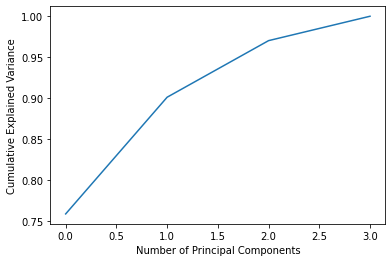

Principal_component_1  Principal_component_2  Principal_component_3  \
0                 -8.128638              -2.390167               1.153644   
1                 -7.811304              -2.712167               1.571305   
2                  3.674734              -4.399368              -0.155923   
3                 -9.917815              -0.989089               0.519711   
4                  6.942445              -0.772452              -0.369837   
...                     ...                    ...                    ...   
1367              -0.988750              -1.198333              -2.569613   
1368               8.795215               0.528851               0.050893   
1369              21.734566               4.807556               3.830455   
1370              14.956474               3.804900               2.164758   
1371               3.580436               1.074125              -1.459550   

      Principal_component_4  
0                 -0.971264  
1                  0.392658  
2                  1.339483  
3                  1.586925  
4                  1.295074  
...                     ...  
1367              -0.293191  
1368              -0.553935  
1369               2.977406  
1370               0.665950  
1371              -2.658350  

[1372 rows x 4 columns]

In [29]:
def reduceDimensionsUsingPCA(datasetInDataFrameFormat, NumOfPCAcomponents):
    pca = PCA(n_components = NumOfPCAcomponents)
    pca.fit(datasetInDataFrameFormat)
    #plot the variance graph
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()
    #transform the pca to dataframe
    df = pca.transform(datasetInDataFrameFormat)
    #setting the column names
    colNames = []
    for i in range(NumOfPCAcomponents):    
        colNames.append(f"Principal_component_{i+1}")
    df = pd.DataFrame(data = df, columns = colNames)
    return df

#uncommment below code for tesing
reduceDimensionsUsingPCA(df, getDatasetDimensionality(df))
    

[Click here to go to FunctionsList](#FunctionsList)
### <a id='scaleDatasetUsingStandardScalar'>Function Name: scaleDatasetUsingStandardScalar()</a>
__Description:__ 
To scale the features into unit scale for faster processing.(see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

__Inputs:__
1. datasetInDataFrameFormat: dataset in pandas dataframe format to be scaled

__Return:__
1. scaled dataset in pandas dataframe format

In [30]:
def scaleDatasetUsingStandardScalar(datasetInDataFrameFormat):
    columnNames = datasetInDataFrameFormat.columns
    df=StandardScaler().fit_transform(datasetInDataFrameFormat)
    df = pd.DataFrame(data = df, columns = columnNames)
    return df
    
#uncommment below code for tesing
scaleDatasetUsingStandardScalar(df)

variance  skewness  curtosis   entropy     class
0     1.121806  1.149455 -0.975970  0.354561 -0.894721
1     1.447066  1.064453 -0.895036 -0.128767 -0.894721
2     1.207810 -0.777352  0.122218  0.618073 -0.894721
3     1.063742  1.295478 -1.255397 -1.144029 -0.894721
4    -0.036772 -1.087038  0.736730  0.096587 -0.894721
...        ...       ...       ...       ...       ...
1367 -0.009711 -0.097693 -0.660962  0.300996  1.117667
1368 -0.641313 -1.158984  1.179023  0.730127  1.117667
1369 -1.472357 -2.621646  3.759017 -0.754884  1.117667
1370 -1.406693 -1.756471  2.552043 -0.043158  1.117667
1371 -1.047122 -0.439822  0.298616  1.136464  1.117667

[1372 rows x 5 columns]

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getSplitTrainNtestDataUsingStratKfold'>Function Name: getSplitTrainNtestDataUsingStratKfold()</a>
__Description:__ 
To get the split data for training and testing using the stratified K fold splitting approach.(code reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

__Inputs:__
1. InputX : independant input variables for splitting
2. OutputY : dependant output variables for splitting
3. folds: number of folds for stratified K fold splitting

__Return:__
1. X_train, X_test, y_train, y_test: split data for training and testing

In [31]:
def getSplitTrainNtestDataUsingStratKfold(InputX, OutputY, folds=10):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
    #Below loop, goes through all the 10 splits and takes the last split data only
    for train_index, test_index in skf.split(InputX, OutputY):
        X_train, X_test = InputX.iloc[train_index], InputX.iloc[test_index]
        y_train, y_test = OutputY.iloc[train_index], OutputY.iloc[test_index]
    return [X_train, X_test, y_train, y_test]
    
#uncommment below code for tesing
[X_train, X_test, y_train, y_test] = getSplitTrainNtestDataUsingStratKfold(df.drop('class',axis=1), df['class'], stratifiedKfoldSplits)
print([X_train, X_test, y_train, y_test])
    

[      variance  skewness  curtosis  entropy
0      3.62160   8.66610   -2.8073 -0.44699
1      4.54590   8.16740   -2.4586 -1.46210
2      3.86600  -2.63830    1.9242  0.10645
3      3.45660   9.52280   -4.0112 -3.59440
4      0.32924  -4.45520    4.5718 -0.98880
...        ...       ...       ...      ...
1367   0.40614   1.34920   -1.4501 -0.55949
1368  -1.38870  -4.87730    6.4774  0.34179
1369  -3.75030 -13.45860   17.5932 -2.77710
1370  -3.56370  -8.38270   12.3930 -1.28230
1371  -2.54190  -0.65804    2.6842  1.19520

[1235 rows x 4 columns],       variance  skewness  curtosis   entropy
15    4.676500   -3.3895   3.48960  1.477100
33   -0.965110    9.4111   1.73050 -4.862900
46    2.084300    6.6258   0.48382 -2.213400
49    1.634900    3.2860   2.87530  0.087054
56    2.563500    6.7769  -0.61979  0.385760
...        ...       ...       ...       ...
1309 -4.288700   -7.8633  11.83870 -1.897800
1317 -1.266700    2.8183  -2.42600 -1.886200
1324  0.062525    2.9301  -3.54670 -2.67

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getRFpossibleAccuraciesWithStatSplit'>Function Name: getRFpossibleAccuraciesWithStatSplit()</a>
__Description:__ 
To get the possible accuracies for the RF model for a n stratified K fold splits
__Inputs:__
1. InputX : independant input variables for splitting
2. OutputY : dependant output variables for splitting
3. numberOfSplits: number of folds for stratified K fold splitting
4. estimators: number of estimators for RF model

__Return:__
1. accuracies for n splits of data

In [32]:
def getRFpossibleAccuraciesWithStatSplit(InputX, OutputY, numberOfSplits, estimators=200):
    Accuracies = []
    
    RFmodel = RandomForestClassifier(n_estimators = estimators, criterion = 'entropy', random_state = 0)
    skf = StratifiedKFold(n_splits=stratifiedKfoldSplits, shuffle=True, random_state=1)
    #Below loop, goes through all the 10 splits and takes the last split data only
    for train_index, test_index in skf.split(InputX, OutputY):
        X_train, X_test = InputX.iloc[train_index], InputX.iloc[test_index]
        y_train, y_test = OutputY.iloc[train_index], OutputY.iloc[test_index]
        RFmodel.fit(X_train,y_train)
        predicted_y = RFmodel.predict(X_test)
        Accuracies.append(accuracy_score(y_test, predicted_y)*100)#accuracy in percentage
    return Accuracies

#uncommment below code for tesing
print(getRFpossibleAccuraciesWithStatSplit(df.drop('class',axis=1), df['class'],10,200))

[100.0, 99.27536231884058, 98.54014598540147, 99.27007299270073, 97.8102189781022, 99.27007299270073, 99.27007299270073, 100.0, 100.0, 99.27007299270073]


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getRandomForestModelForDataset'>Function Name: getRandomForestModelForDataset()</a>
__Description:__ 
To generate the random forest model for the trained data of a dataset provided.(see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

__Inputs:__
1. X_train : independant variables for training in pandas dataframe format
2. Y_train : dependant variables for training in pandas dataframe format
3. estimators: number of estimators for random forest

__Return:__
1. random forest model generated using the trained data

In [33]:
def getRandomForestModelForDataset(X_train, Y_train, estimators=200):
    RFmodel = RandomForestClassifier(n_estimators = estimators, criterion = 'entropy', random_state = 0)
    RFmodel.fit(X_train,Y_train)
    #RFmodel.fit(X_train, reshaped_y_train.ravel())
    return RFmodel
    
#uncommment below code for tesing
RFmodel = getRandomForestModelForDataset(df.drop('class',axis=1), df['class'], estimators4RandomForest)
print(RFmodel)

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getPredictedValuesNaccuracy'>Function Name: getPredictedValuesNaccuracy()</a>
__Description:__ 
To generate the predicted values and accuracy for a model using test inputs and expected outputs.
__Inputs:__
1. model : generated model classifier for a trained dataset
2. X_Test : dependant variables for testing in pandas dataframe format
3. expected_y: expected output for a test dataset

__Return:__
1. predicted_y, accuracy: predicted outputs and accuracy of the model for the predicted outputs

In [34]:
def getPredictedValuesNaccuracy(model, X_Test, expected_y):
    predicted_y = model.predict(X_Test)
    return [predicted_y, accuracy_score(expected_y, predicted_y)*100]#accuracy in percentage

#uncommment below code for tesing
[y_pred, Modelaccuracy] = getPredictedValuesNaccuracy(RFmodel, X_test, y_test)
print(y_pred)
print(Modelaccuracy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
100.0


[Click here to go to FunctionsList](#FunctionsList)
### <a id='displayMultivariateAnalysisPlot'>Function Name: displayMultivariateAnalysisPlot()</a>
__Description:__ 
To display pair plot for the multivariate analysis of features and classes (see https://www.youtube.com/watch?v=IkvwXPEBlNo&t=801s )
__Inputs:__
1. datasetInDataFrameFormat : dataset in pandas data frame format
2. classColName : colum name where output/classes/labels are present
3. NumberOfColumns: number of features in a dataset

__Return:__
1. pair plots helping multivatiate analysis

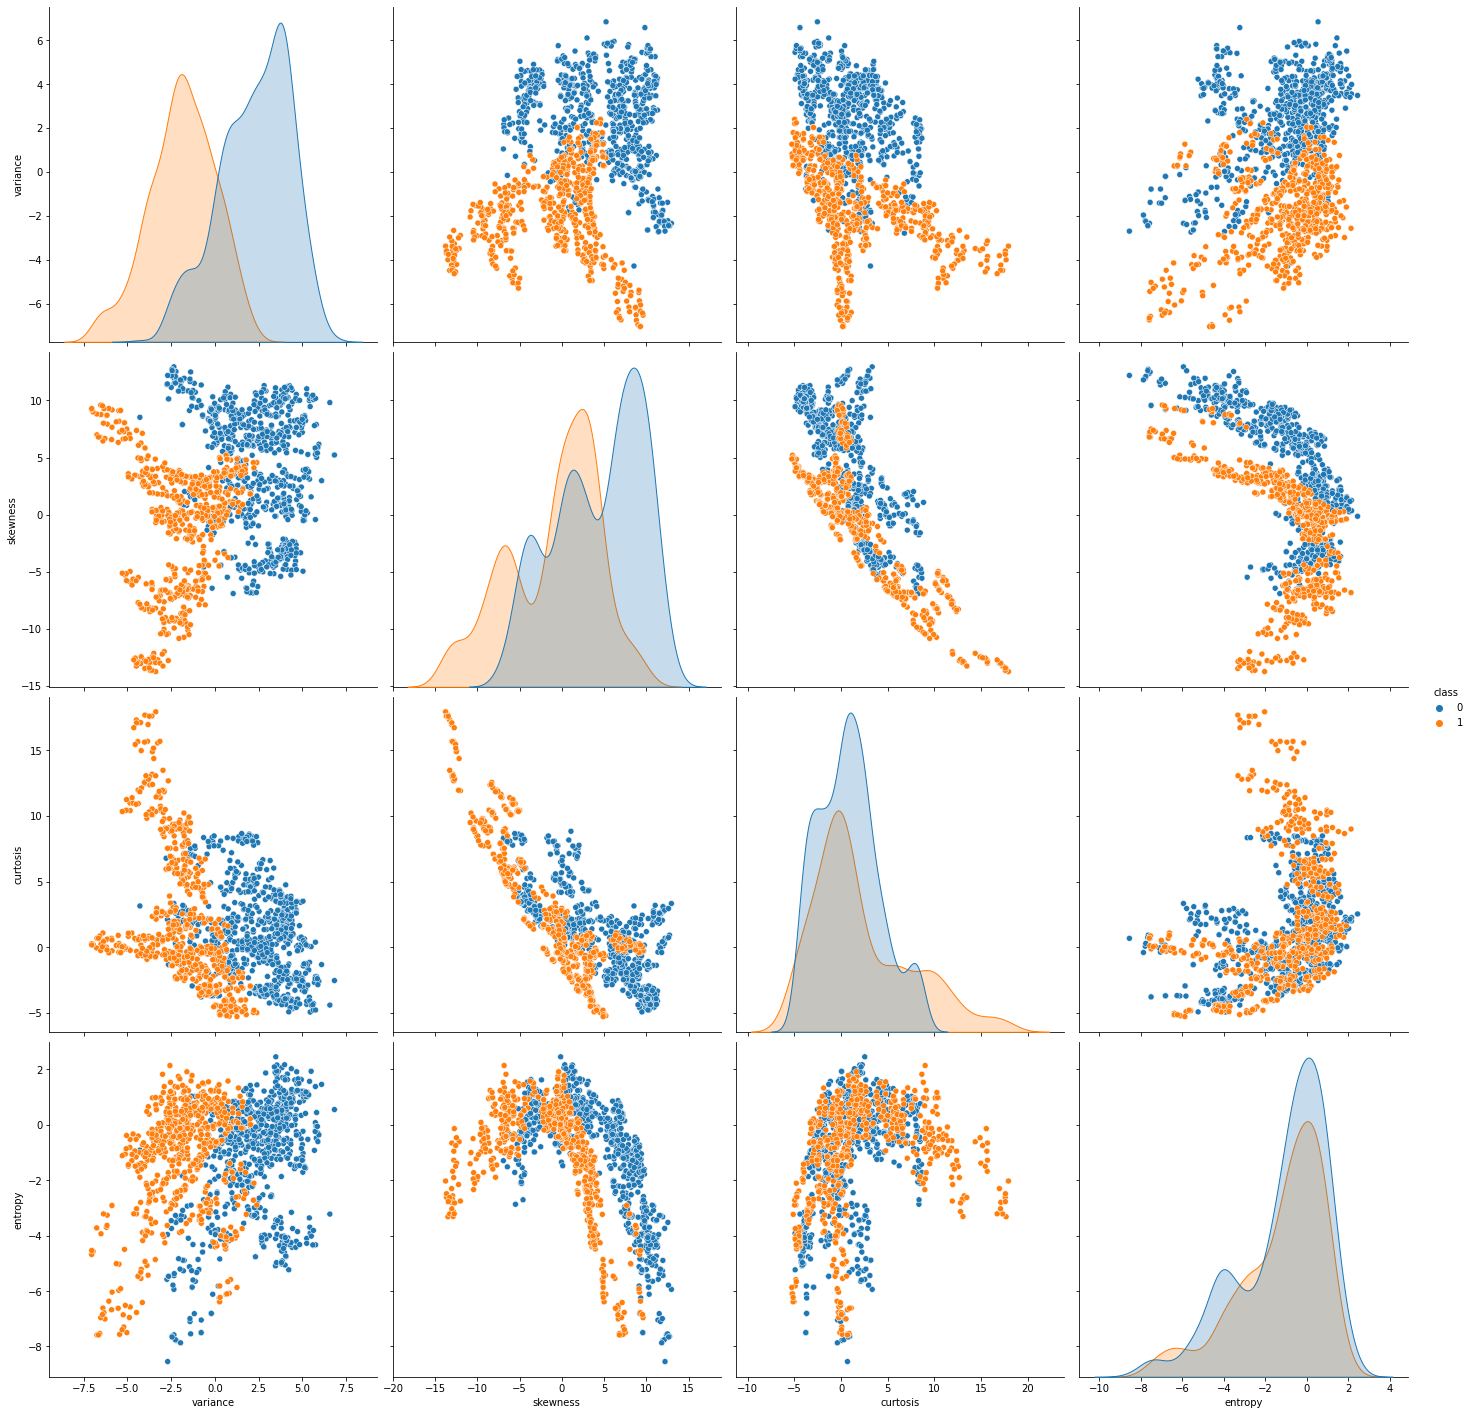

In [35]:
def displayMultivariateAnalysisPlot(datasetInDataFrameFormat, classColName, NumberOfColumns):
    sns.pairplot(datasetInDataFrameFormat, hue=classColName, height=NumberOfColumns)
    plt.show()

#uncommment below code for tesing
displayMultivariateAnalysisPlot(df, 'class', 5)

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getAllStatDistMeasureForAclassTrainNtestInputs'>Function Name: getAllStatDistMeasureForAclassTrainNtestInputs()</a>
__Description:__ 
function to calculate all the distance measure values for all the features of a class/label using test and train data
__Inputs:__
1. X_trainForAclass : train dataset for a class in pandas data frame format
2. X_testForAclass : test dataset for a class in pandas data frame format

__Return:__
1. df_distMesasures: all the distance measures for all the features of a dataset in a class in pandas dataframe format

In [36]:
def getAllStatDistMeasureForAclassTrainNtestInputs(X_trainForAclass, X_testForAclass):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = len(X_trainForAclass.columns)
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_trainForAclass.iloc[:, i], X_testForAclass.iloc[:, i])
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_trainForAclass.iloc[:, i], X_testForAclass.iloc[:, i])
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_trainForAclass.iloc[:, i], X_testForAclass.iloc[:, i])
        Kuiper_distances[i] = Kuiper_Dist(X_trainForAclass.iloc[:, i], X_testForAclass.iloc[:, i])
        Wasserstein_distances[i] = Wasserstein_Dist(X_trainForAclass.iloc[:, i], X_testForAclass.iloc[:, i])
        DTS_distances[i] = DTS_Dist(X_trainForAclass.iloc[:, i], X_testForAclass.iloc[:, i])
    
    #Summing all the distance measures
    CVM_dist_sum = np.sum(CVM_distances, dtype=np.float64)
    DTS_dist_sum = np.sum(DTS_distances, dtype=np.float64)
    Anderson_Darling_dist_sum = np.sum(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_dist_sum = np.sum(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_dist_sum = np.sum(Kuiper_distances, dtype=np.float64)
    Wasserstein_dist_sum = np.sum(Wasserstein_distances, dtype=np.float64)
    
    #col_names = ['Anderson_Darling_dists', 'CVM_dists', 'DTS_dists', 'Kolmogorov_Smirnov_dists', 'Kuiper_dists', 'Wasserstein_dists']
    #storing all the distance measures to pandas dataframe
    df_distMesasures = pd.DataFrame()
    df_distMesasures['Feature'] = X_trainForAclass.columns.tolist()
    df_distMesasures['Anderson_Darling'] = Anderson_Darling_distances.tolist()
    df_distMesasures['CVM'] = CVM_distances.tolist()
    df_distMesasures['DTS'] = DTS_distances.tolist()
    df_distMesasures['Kolmogorov_Smirnov'] = Kolmogorov_Smirnov_distances.tolist()
    df_distMesasures['Kuiper'] = Kuiper_distances.tolist()
    df_distMesasures['Wasserstein'] = Wasserstein_distances.tolist()
    df_distMesasures.loc[len(df_distMesasures.index)] = ['SUM =>', Anderson_Darling_dist_sum, CVM_dist_sum, DTS_dist_sum,
                                                        Kolmogorov_Smirnov_dist_sum, Kuiper_dist_sum, Wasserstein_dist_sum]
    
    return df_distMesasures

#uncommment below code for tesing
#df.loc[df['class']==1]
getAllStatDistMeasureForAclassTrainNtestInputs(X_train, X_test)

Feature  Anderson_Darling         CVM       DTS  Kolmogorov_Smirnov  \
0  variance          4.236185   57.412542  0.048878            0.121002   
1  skewness          1.479715   19.357115  0.040670            0.044759   
2  curtosis          1.891254   26.140051  0.045911            0.050658   
3   entropy          3.073370   45.296474  0.030558            0.080800   
4    SUM =>         10.680525  148.206182  0.166018            0.297219   

     Kuiper  Wasserstein  
0  0.189574     0.510445  
1  0.079116     0.416846  
2  0.060735     0.422504  
3  0.110009     0.346023  
4  0.439434     1.695819

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getTrainNtestFeatues4APredictedLabel'>Function Name: getTrainNtestFeatues4APredictedLabel()</a>
__Description:__ 
This function is used to get the trained and test input featues for a specific label using trained and predicted output features. This will be useful for the statistical distance measure calculations.
__Inputs:__
1. df_X_train : train dataset for a label in pandas data frame format
2. df_X_test : test dataset for a label in pandas data frame format
3. df_Y_train : train dataset for a label in pandas data frame format
4. df_Y_predicted : test dataset for a label in pandas data frame format
5. label : label for which the calculation to be done

__Return:__
1. [X_train_Class, X_test_Class] - training and test dataset features for a specified label in the output

In [37]:
def getTrainNtestFeatures4APredictedLabel(df_X_train, df_X_test, df_Y_train, df_Y_predicted, label):
    X_train_Class = df_X_train.loc[df_Y_train == label]
    X_test_Class = df_X_test.loc[df_Y_predicted == label]
    return [X_train_Class, X_test_Class]
    
#uncommment below code for tesing
getTrainNtestFeatures4APredictedLabel(X_train, X_test, y_train, y_pred, 0)

[     variance  skewness  curtosis  entropy
 0     3.62160   8.66610  -2.80730 -0.44699
 1     4.54590   8.16740  -2.45860 -1.46210
 2     3.86600  -2.63830   1.92420  0.10645
 3     3.45660   9.52280  -4.01120 -3.59440
 4     0.32924  -4.45520   4.57180 -0.98880
 ..        ...       ...       ...      ...
 756   4.01270  10.14770  -3.93660 -4.07280
 757   2.66060   3.16810   1.96190  0.18662
 759   0.01727   8.69300   1.39890 -3.96680
 760   3.24140   0.40971   1.40150  1.19520
 761   2.25040   3.57570   0.35273  0.28360
 
 [686 rows x 4 columns],
      variance  skewness  curtosis   entropy
 15    4.67650   -3.3895  3.489600  1.477100
 33   -0.96511    9.4111  1.730500 -4.862900
 46    2.08430    6.6258  0.483820 -2.213400
 49    1.63490    3.2860  2.875300  0.087054
 56    2.56350    6.7769 -0.619790  0.385760
 ..        ...       ...       ...       ...
 683   4.33650   -3.5840  3.688400  0.749120
 689   3.02420   -3.3378  2.586500 -0.547850
 714   2.55590    3.3605  2.032100  0.26

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getAccuracyNdistMeasures4allFolds'>Function Name: getAccuracyNdistMeasures4allFolds()</a>
__Description:__ 
This function is used to get the accuracies and statistical distance measures for all the folds used for train and test of a model.
__Inputs:__
1. df_Dataset : Dataset in pandas data frame format
2. className : class column name
3. label : label name for which calculations to be done

__Return:__
1. df_AccuracyNDists - all the accuracies and distance measures for all the folder in pandas df format

In [38]:
def getAccuracyNdistMeasures4allFolds(df_Dataset, className, label):
    df_X = df_Dataset.drop(className, axis=1)
    df_Y = df_Dataset[className]
    Accuracies = []
    col_names = ['Anderson_Darling', 'CVM', 'DTS', 'Kolmogorov_Smirnov', 'Kuiper', 'Wasserstein']
    df_AccuracyNDists = pd.DataFrame(columns = col_names)
    
    RFmodel = RandomForestClassifier(n_estimators = estimators4RandomForest, criterion = 'entropy', random_state = 0)
    skf = StratifiedKFold(n_splits=stratifiedKfoldSplits, shuffle=True, random_state=1)
    
    #Below loop, goes through all the 10 splits and takes the last split data only
    for train_index, test_index in skf.split(df_X, df_Y):
        df_X_train, df_X_test = df_X.iloc[train_index], df_X.iloc[test_index]
        df_Y_train, df_Y_test = df_Y.iloc[train_index], df_Y.iloc[test_index]
        RFmodel.fit(df_X_train,df_Y_train)
        df_Y_predicted = RFmodel.predict(df_X_test)
        Accuracies.append(accuracy_score(df_Y_test, df_Y_predicted)*100)#accuracy in percentage
        
        [X_train_label, X_test_label] = getTrainNtestFeatures4APredictedLabel(df_X_train, df_X_test, df_Y_train, df_Y_predicted, label)
        df_AllStatDists = getAllStatDistMeasureForAclassTrainNtestInputs(X_train_label, X_test_label)
        
        df_AllStatDists = df_AllStatDists.drop('Feature', axis=1)
        #columns = df_AllStatDists.columns.tolist()
        sum_All_dists = df_AllStatDists.values[-1].tolist()

        df_AccuracyNDists.loc[len(df_AccuracyNDists.index)] = sum_All_dists
    
    df_AccuracyNDists['Accuracy'] = Accuracies
    
    return df_AccuracyNDists
        
#uncommment below code for tesing
df_AccuracyNDists = getAccuracyNdistMeasures4allFolds(df,'class', 0)
df_AccuracyNDists

Anderson_Darling         CVM       DTS  Kolmogorov_Smirnov    Kuiper  \
0          8.075342   89.225576  0.159237            0.373571  0.540203   
1         10.585514  114.271233  0.195569            0.440427  0.727569   
2         12.256330  132.802261  0.211791            0.432826  0.580451   
3         10.397825  113.238542  0.190353            0.467949  0.666278   
4          8.990137   94.677901  0.165015            0.402293  0.659767   
5          7.199143   78.004781  0.164416            0.349329  0.517648   
6          7.578304   79.923930  0.165146            0.305470  0.452279   
7         13.228230  146.027658  0.230044            0.482929  0.620723   
8         14.782132  163.613549  0.269972            0.522441  0.636182   
9         11.001703  122.603712  0.218631            0.450224  0.570826   

   Wasserstein    Accuracy  
0     1.447688  100.000000  
1     1.697874   99.275362  
2     1.955788   98.540146  
3     1.761667   99.270073  
4     1.403151   97.810219  
5     1.490515   99.270073  
6     1.485855  100.000000  
7     2.044270  100.000000  
8     2.515325  100.000000  
9     2.057315   99.270073

[Click here to go to FunctionsList](#FunctionsList)
### <a id='displayScatterPlot4AllDistsNAccuracies'>Function Name: displayScatterPlot4AllDistsNAccuracies()</a>
__Description:__ 
This function is used to get the accuracies and statistical distance measures for all the folds used for train and test of a model.

__Inputs:__
1. df_DistsNAccuracies : All distance and accuracies in pandas data frame format
2. labelName : label name to display in graphs

__Return:__
1. scatter plot for all the distance measures with accuracies

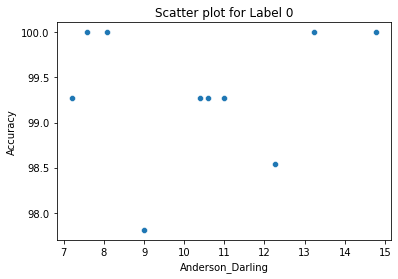

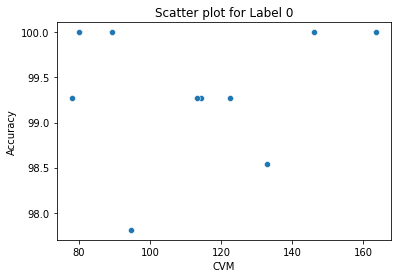

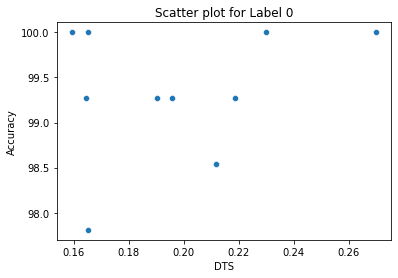

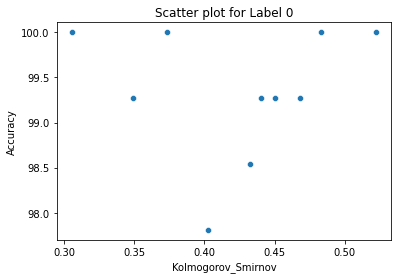

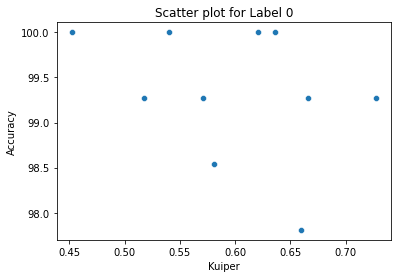

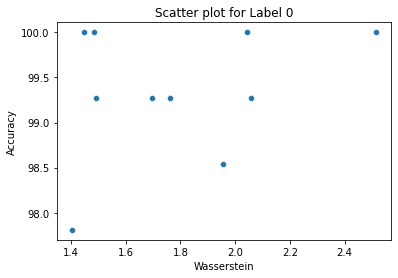

In [39]:
def displayScatterPlot4AllDistsNAccuracies(df_DistsNAccuracies, labelName):
    df_Dists = df_DistsNAccuracies.drop('Accuracy', axis=1)
    for (columnName, columnData) in df_Dists.iteritems():
        #print('Column Name : ', columnName)
        #print('Column Contents : ', columnData.values)
        sns.scatterplot(x=columnName, y="Accuracy", data=df_DistsNAccuracies)
        plt.title('Scatter plot for Label ' + labelName)
        plt.show()
    
#uncommment below code for tesing
displayScatterPlot4AllDistsNAccuracies(df_AccuracyNDists, "0")

[Click here to go to FunctionsList](#FunctionsList)
### <a id='getPearsonCorrValues4allDistsNAccuracies'>Function Name: getPearsonCorrValues4allDistsNAccuracies()</a>
__Description:__ 
This function is used to get the correlation between all the accuracies and statistical distance measures

__Inputs:__
1. df_DistsNAccuracies : All distance and accuracies in pandas data frame format

__Return:__
1. correlation value of all the distance measures with accuracy in dataframe format

In [40]:
def getPearsonCorrValues4allDistsNAccuracies(df_DistsNAccuracies):
    df_Dists = df_DistsNAccuracies.drop('Accuracy', axis=1)
    col_names = df_Dists.columns.tolist()
    correlation = []
    #loop through all the dists and accuracies to find the correlation
    for (columnName, columnData) in df_Dists.iteritems():
        df = df_DistsNAccuracies[[columnName, 'Accuracy']]
        corrAccurNDists = df.corr()
        correlation.append(corrAccurNDists.loc[columnName, 'Accuracy'])
    #creating a dataframe to store correlation values for all distance measures
    df_correlation = pd.DataFrame(columns = col_names)
    df_correlation.loc[len(df_correlation.index)] = correlation
    return df_correlation
    
#uncommment below code for tesing
df_CorrAccuracyNDists = getPearsonCorrValues4allDistsNAccuracies(df_AccuracyNDists) 
print(df_CorrAccuracyNDists)

   Anderson_Darling       CVM       DTS  Kolmogorov_Smirnov   Kuiper  \
0          0.134481  0.168846  0.265415            0.041517 -0.33978   

   Wasserstein  
0     0.295518  


[Click here to go to FunctionsList](#FunctionsList)
### <a id='getBestDistanceMeasureForDataset'>Function Name: getBestDistanceMeasureForDataset()</a>
__Description:__ 
This function is used to get the best distance measure for a dataset among all the distance measure values

__Inputs:__
1. df_DistsNAccuraciesClasses : Mean of all distance and accuracies for all classes in pandas data frame format
2. method: method used for calculating the best distance measure and can take min, min_mean, max_mean and max

__Return:__
1. Best distance mesaure, calculated distance and method used

In [41]:
def getBestDistanceMeasureForDataset(lst_df_DistsNAccuraciesClass, method='min_mean'):
    df_concat = lst_df_DistsNAccuraciesClass[0]
    for i in range(1,len(lst_df_DistsNAccuraciesClass)):
        df_concat = pd.concat([df_concat, lst_df_DistsNAccuraciesClass[i]], axis=0, ignore_index=True)
    if method == 'min_mean':
        df_mean = df_concat.abs().mean(axis=0)
        Value = df_mean.min(axis=0)
        for (columnName, columnData) in df_mean.iteritems():
            if(columnData == Value):
                colName = columnName
    elif method == 'max_mean':
        df_mean = df_concat.abs().mean(axis=0)
        Value = df_mean.max(axis=0)
        for (columnName, columnData) in df_mean.iteritems():
            if(columnData == Value):
                colName = columnName
    elif method == 'min':
        Value = df_concat.abs().min().min()
        for (columnName, columnData) in df_concat.abs().min().iteritems():
            if(columnData == Value):
                colName = columnName
    elif method == 'max':
        Value = df_concat.abs().max().max()
        for (columnName, columnData) in df_concat.abs().max().iteritems():
            if(columnData == Value):
                colName = columnName

    return ([colName, Value, method])
    
#uncommment below code for tesing
lst_df_CorrAccuracyNDists = []
lst_df_CorrAccuracyNDists.append(df_CorrAccuracyNDists)
lst_df_CorrAccuracyNDists.append(df_CorrAccuracyNDists)
#print(lst_df_CorrAccuracyNDists)
print(getBestDistanceMeasureForDataset(lst_df_CorrAccuracyNDists, 'min_mean'))
print(getBestDistanceMeasureForDataset(lst_df_CorrAccuracyNDists, 'max_mean'))
print(getBestDistanceMeasureForDataset(lst_df_CorrAccuracyNDists, 'min'))
print(getBestDistanceMeasureForDataset(lst_df_CorrAccuracyNDists, 'max'))

['Kolmogorov_Smirnov', 0.041516811182573235, 'min_mean']
['Kuiper', 0.3397797052587953, 'max_mean']
['Kolmogorov_Smirnov', 0.041516811182573235, 'min']
['Kuiper', 0.3397797052587953, 'max']


[Click here to go to FunctionsList](#FunctionsList)
### <a id='populateDatasetCharaNdistMeasureTable'>Function Name: populateDatasetCharaNdistMeasureTable()</a>
__Description:__ 
This function is used to compute and populate the table for dataset characteristics and the best distance measure for the analysis. 

__Inputs:__
1. datasetsPath : Directory where all the datasets for the analysis are stored

__Return:__
1. Table populated with dataset characteristics and best distance measure in pandas dataframe format

In [42]:
def populateDatasetCharaNdistMeasureTable(datasetsPath):
    #code ref: https://www.geeksforgeeks.org/getting-all-csv-files-from-a-directory-using-python/
    lstFiles = glob.glob(datasetsPath + "/*.csv") #read all the filenames into a list
    lstParams = []
    lstVals = []
    lstCols = ['Parameters']
    #lstFileNames = []
    i=0
    for filename in lstFiles:
        start_time = time.time()#start time
        df_dataset = pd.read_csv(filename, index_col=None) #read the dataset into a dataframe
        df_dataset = fixDatasetColumnName(df_dataset)#Colum name corrected by removing sa
        strClassName = df_dataset.columns[df_dataset.shape[1]-1] #read the class name, assumed as the last column name
        NrOfClasses = getDatasetNumberOfClasses(df_dataset,strClassName)#number of classes
        df_X = df_dataset.drop(strClassName,axis=1) #Features column
        df_Y = df_dataset[strClassName]#Class column
        lstLabelNames = df_Y.unique()
        
        df_datasetChara = getAllDatasetCharacteristicsTable(df_dataset, strClassName)
        df_datasetCharaParams = df_datasetChara['Parameters']#splitting for the purpose of merging later
        df_datasetCharaVals = df_datasetChara['Value']
        
        #file names to the table
        #lstFileNames.append(filename.split('\\')[1])
        df_datasetCharaParams.loc[len(df_datasetCharaParams.index)] = 'File Name'
        df_datasetCharaVals.loc[len(df_datasetCharaVals.index)] = filename.split('\\')[1]
                
        lstParams.append(df_datasetCharaParams)
        lstVals.append(df_datasetCharaVals)
        i = i+1
        lstCols.append('Value'+str(i))
        
        #find all the distance measures for feature and accuracies for all classes, for all K-folds train and test sets
        lst_df_corrDistNAccrLabel = []
        for labelName in lstLabelNames:
            df_DistsNAccuraciesLabel = getAccuracyNdistMeasures4allFolds(df_dataset, strClassName, labelName)
            lst_df_corrDistNAccrLabel.append(getPearsonCorrValues4allDistsNAccuracies(df_DistsNAccuraciesLabel))
        
        #finding the best distance measure and value
        lst_BestDistMeasure = getBestDistanceMeasureForDataset(lst_df_corrDistNAccrLabel, method='min_mean')#min, min_mean, max_mean, max

        df_datasetCharaParams.loc[len(df_datasetCharaParams.index)] = 'Distance Measure (min_mean)'
        df_datasetCharaVals.loc[len(df_datasetCharaVals.index)] = lst_BestDistMeasure[0]
        
        finish_time = time.time()#end time
        exe_time = finish_time - start_time
        
        df_datasetCharaParams.loc[len(df_datasetCharaParams.index)] = 'Execution time (seconds)'
        df_datasetCharaVals.loc[len(df_datasetCharaVals.index)] = exe_time
        
        #creating the table
        df_Table1 = pd.DataFrame(columns=lstCols)
        df_Table1['Parameters'] = lstParams[0]
    
    #merging the calculated data to table
    i=0
    for val in lstVals:
        i = i+1
        df_Table1['Value'+str(i)] = val
    
    #changing the table format - row to columns and vice versa
    df_Table2 = pd.DataFrame(columns=df_Table1['Parameters'])
    i=0
    for i in range (df_Table1.shape[1]-1):
        i = i+1
        df_Table2.loc[len(df_Table2.index)] = df_Table1['Value'+str(i)].tolist()
    
    return df_Table2#df_Table1#

#uncommment below code for tesing
df_TableMerged = populateDatasetCharaNdistMeasureTable(datasetsPath)
df_TableMerged

Parameters  Dimensionality (d)  NrOfInstances (N)  NrOfClasses (C)  \
0                            4               1372                2   
1                            8                768                2   
2                           13                303                2   

Parameters  ZeroSparsity (OS)  NaNSparsity (NS)  DataSparsity (DS)  \
0                    0.138848               0.0           1.189207   
1                    0.124023               0.0           1.090508   
2                    0.193450               0.0           1.054766   

Parameters DataSparsityRatio (DSR)  \
0                              TBD   
1                              TBD   
2                              TBD   

Parameters  Correlation of Featues with Class (CorrFC)  \
0                                             0.446389   
1                                             0.159899   
2                                             0.107005   

Parameters  Correlation of Featues without Class (CorrFNC)  \
0                                                 0.425625   
1                                                 0.171657   
2                                                 0.135195   

Parameters  Multivariate normality? (MVN)  \
0                                   False   
1                                   False   
2                                   False   

Parameters  Homogeneity of class covariance (HCCov)  \
0                                               1.0   
1                                               1.0   
2                                               1.0   

Parameters  Intrinsic Dimensionality-PCA (ID)  \
0                                           3   
1                                           2   
2                                           3   

Parameters  Intrinsic Dimensionality Ratio (IDR)  \
0                                       0.750000   
1                                       0.250000   
2                                       0.230769   

Parameters  Feature Noise variance (FN1)  Feature Noise paper (FN2)  \
0                              16.379406                   0.250000   
1                            1893.059472                   0.750000   
2                             277.399924                   0.769231   

Parameters                         File Name Distance Measure (min_mean)  \
0           data_banknote_authentication.csv          Kolmogorov_Smirnov   
1                               diabetes.csv                         CVM   
2                                  heart.csv                      Kuiper   

Parameters  Execution time (seconds)  
0                         108.344733  
1                          96.587473  
2                          67.724438

[Click here to go to FunctionsList](#FunctionsList)
### <a id='saveDataframeToCSV'>Function Name: saveDataframeToCSV()</a>
__Description:__ 
This function saves the data in pandas data frame format to csv in the given location

__Inputs:__
1. df_Data : Data in data frame format to be converted to csv
2. filePath2Save : full file path for the file to be saved

__Return:__
1. NA

In [43]:
#code reference: https://pythonguides.com/python-dataframe-to-csv/
def saveDataframeToCSV(df_Data, filePath2Save):
    df_Data.to_csv (filePath2Save)
    
#uncommment below code for tesing
filePath = datasetsPath+'/merged.csv'
saveDataframeToCSV(df_TableMerged, filePath)

[Click here to go to FunctionsList](#FunctionsList)
### <a id='drawNSaveDecisionTree'>Function Name: drawNSaveDecisionTree()</a>
__Description:__ 
This function plot and saves the decision tree for the dataset

__Inputs:__
1. df_Dataset : Dataset in pandas dataframe format
2. className : class name
3. savePath : Path where the plot needs to be saved

__Return:__
1. NA

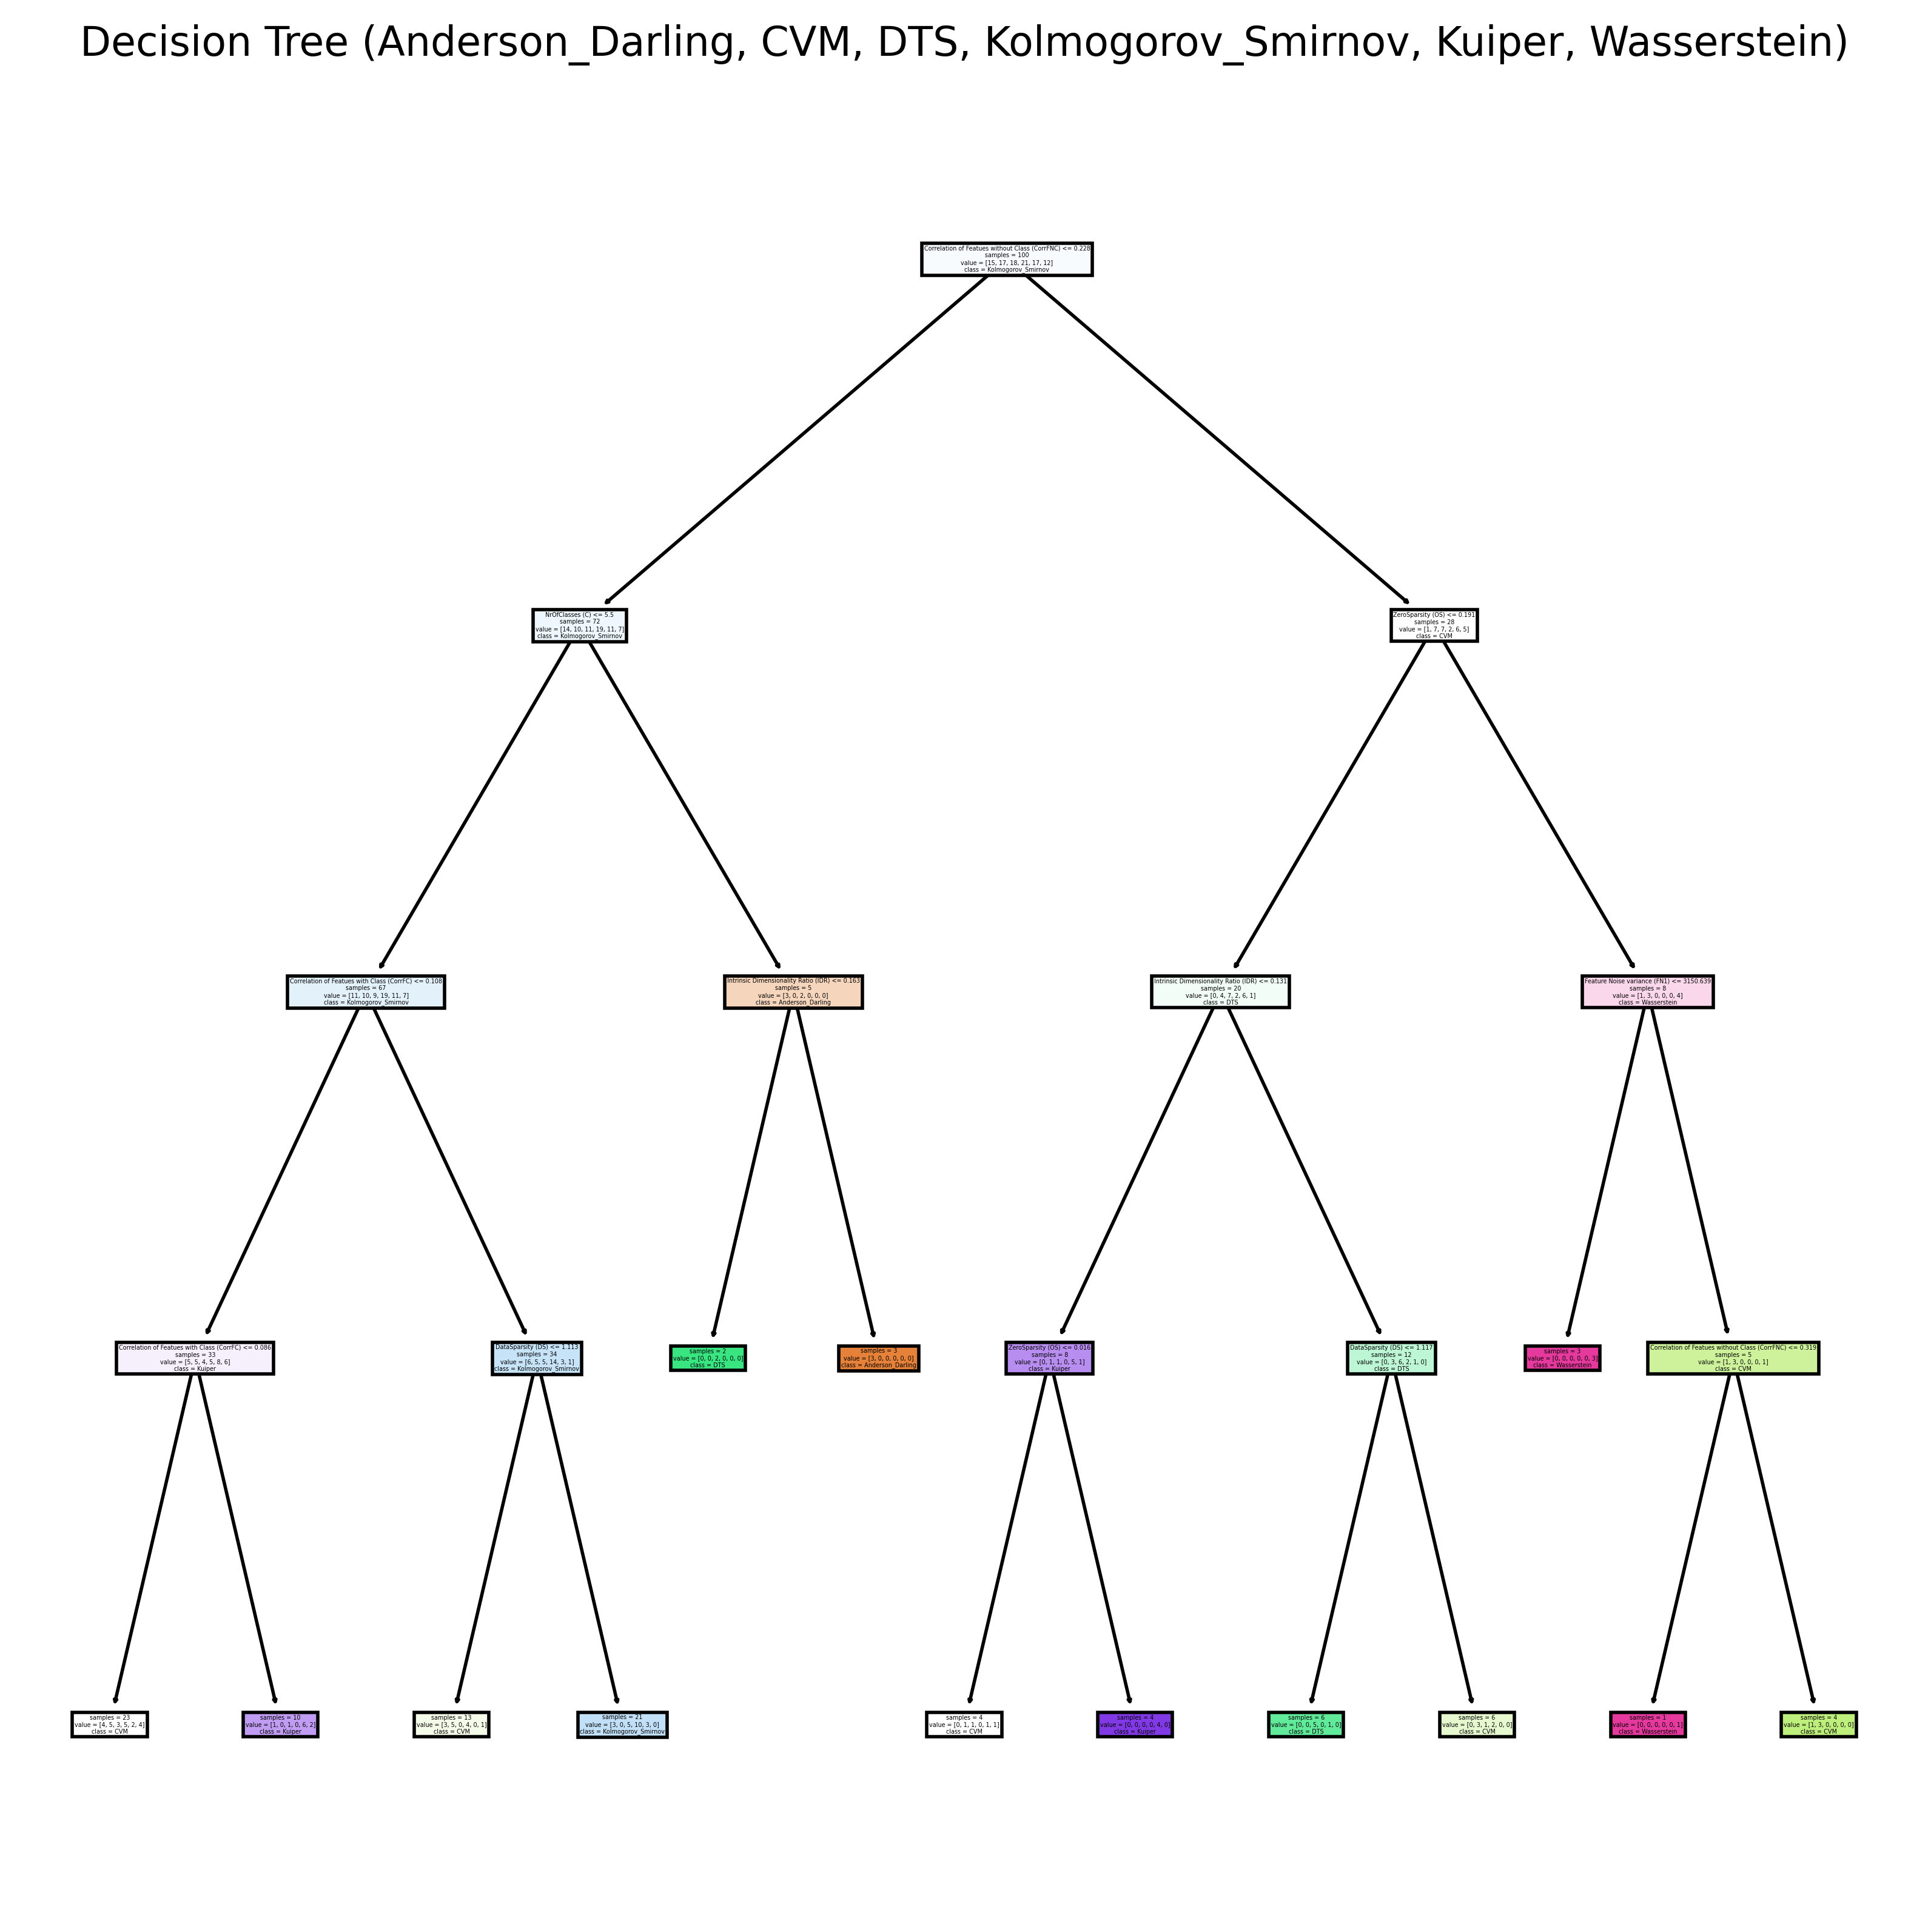

In [44]:
#https://machinelearningknowledge.ai/decision-tree-classifier-in-python-sklearn-with-example/
def drawNSaveDecisionTree(df_Dataset, className, savePath):
    df_X = df_Dataset.drop(className,axis=1)
    df_Y = df_Dataset[className]
    
    #converting the type to integers for better modelling
    #df_X['Dimensionality (d)'] = df_X['Dimensionality (d)'].astype(int)
    #df_X['NrOfInstances (N)'] = df_X['NrOfInstances (N)'].astype(int)
    #df_X['NrOfClasses (C)'] = df_X['NrOfClasses (C)'].astype(int)
    #df_X['Intrinsic Dimensionality-PCA (ID)'] = df_X['Intrinsic Dimensionality-PCA (ID)'].astype(int)
    
    clf_model = DecisionTreeClassifier(max_depth = 4,  random_state = 0)
    #Train the model on the data
    clf_model.fit(df_X, df_Y)
    fns = list(df_X.columns)
    cns =list(df_Y.unique())
    cns.sort()#sorting the order to correct the diagram
    #cns=['AD','CVM','DTS','KSD','KD','WD']
    str = ", "
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=400)
    tree.plot_tree(clf_model,feature_names = fns,class_names=cns,filled = True,impurity =False);
    plt.title(label="Decision Tree"+' ('+str.join(cns)+')')
    fig.savefig(savePath)

#uncommment below code for tesing
df_origDataset = readDataset2DataFrame('./Datasets/FinalDatasets/FinalResult/consolidatedTableSmall.csv')
drawNSaveDecisionTree(df_origDataset, 'Distance Measure (min_mean)', 'Result_1.png')

[Click here to go to FunctionsList](#FunctionsList)

# <a id='MainCode'><u>Main Code starts here</a>
    coding for reading a dataset and calulating its statistical distance measures for different classes for a model. Also, dataset characteristics calculations also will be done.
    
## Steps:
    - Read dataset
    - Analysis Data
        - Visualise correlation matrix heatmap
        - Visualise multivariate analysis
    - Dataset cleaning
        - Correct column names
        - NaN ?
        - Categorical feature Encoding ?
    - Seperating dependant and independant features (features and label)
    - Feature scaling?
    - Dimensionality reduction of independant features using PCA ?
    - Modelling/Training
        - Split training and test datasets
        - Model the ML algorithm using random forest classifer
    - Model Validation
        - predictions using test dataset (model validation)
        - Calculate the accuracies(classification report)
        - Visualise Confusion matrix
    - calculate the distance measures
    - correlation (p-value) accuracy and distance measure
    - scatter plot for above
    - draw box plot

In [45]:
#Globals - Overriding the configurations for testing:
datasetsPath = './Datasets/'
testDatasetName = 'data_banknote_authentication.csv'
testDataset1Name = 'diabetes.csv'# 0's
testDataset2Name = 'nba_logreg.csv' #NaN - does not work
testDataset3Name = 'heart.csv' #NaN
className = 'output'#'TARGET_5Yrs'#'Outcome'#'class'
stratifiedKfoldSplits = 10
estimators4RandomForest = 1000

In [46]:
#reading the dataset and storing to pandas dataframe format
df_originalDataset = readDataset2DataFrame(datasetsPath+testDataset3Name)
print(df_originalDataset)

#displaying the datset info
print(df_originalDataset.info())

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  

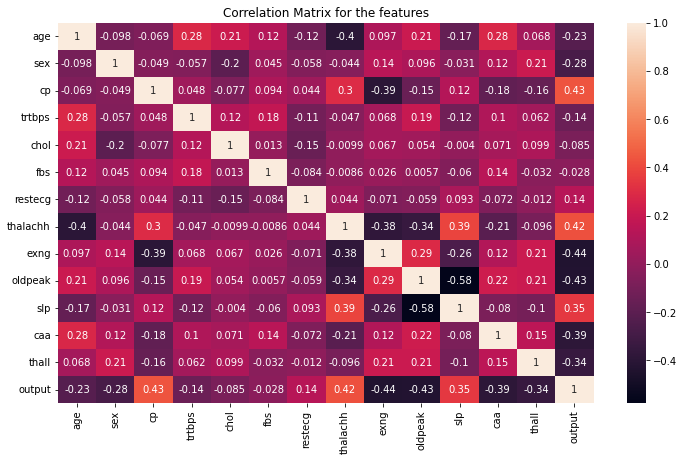

In [47]:
#display correlation matrix for the read dataset features for analysis
displayCorrelationMatrixHeatMap(df_originalDataset)

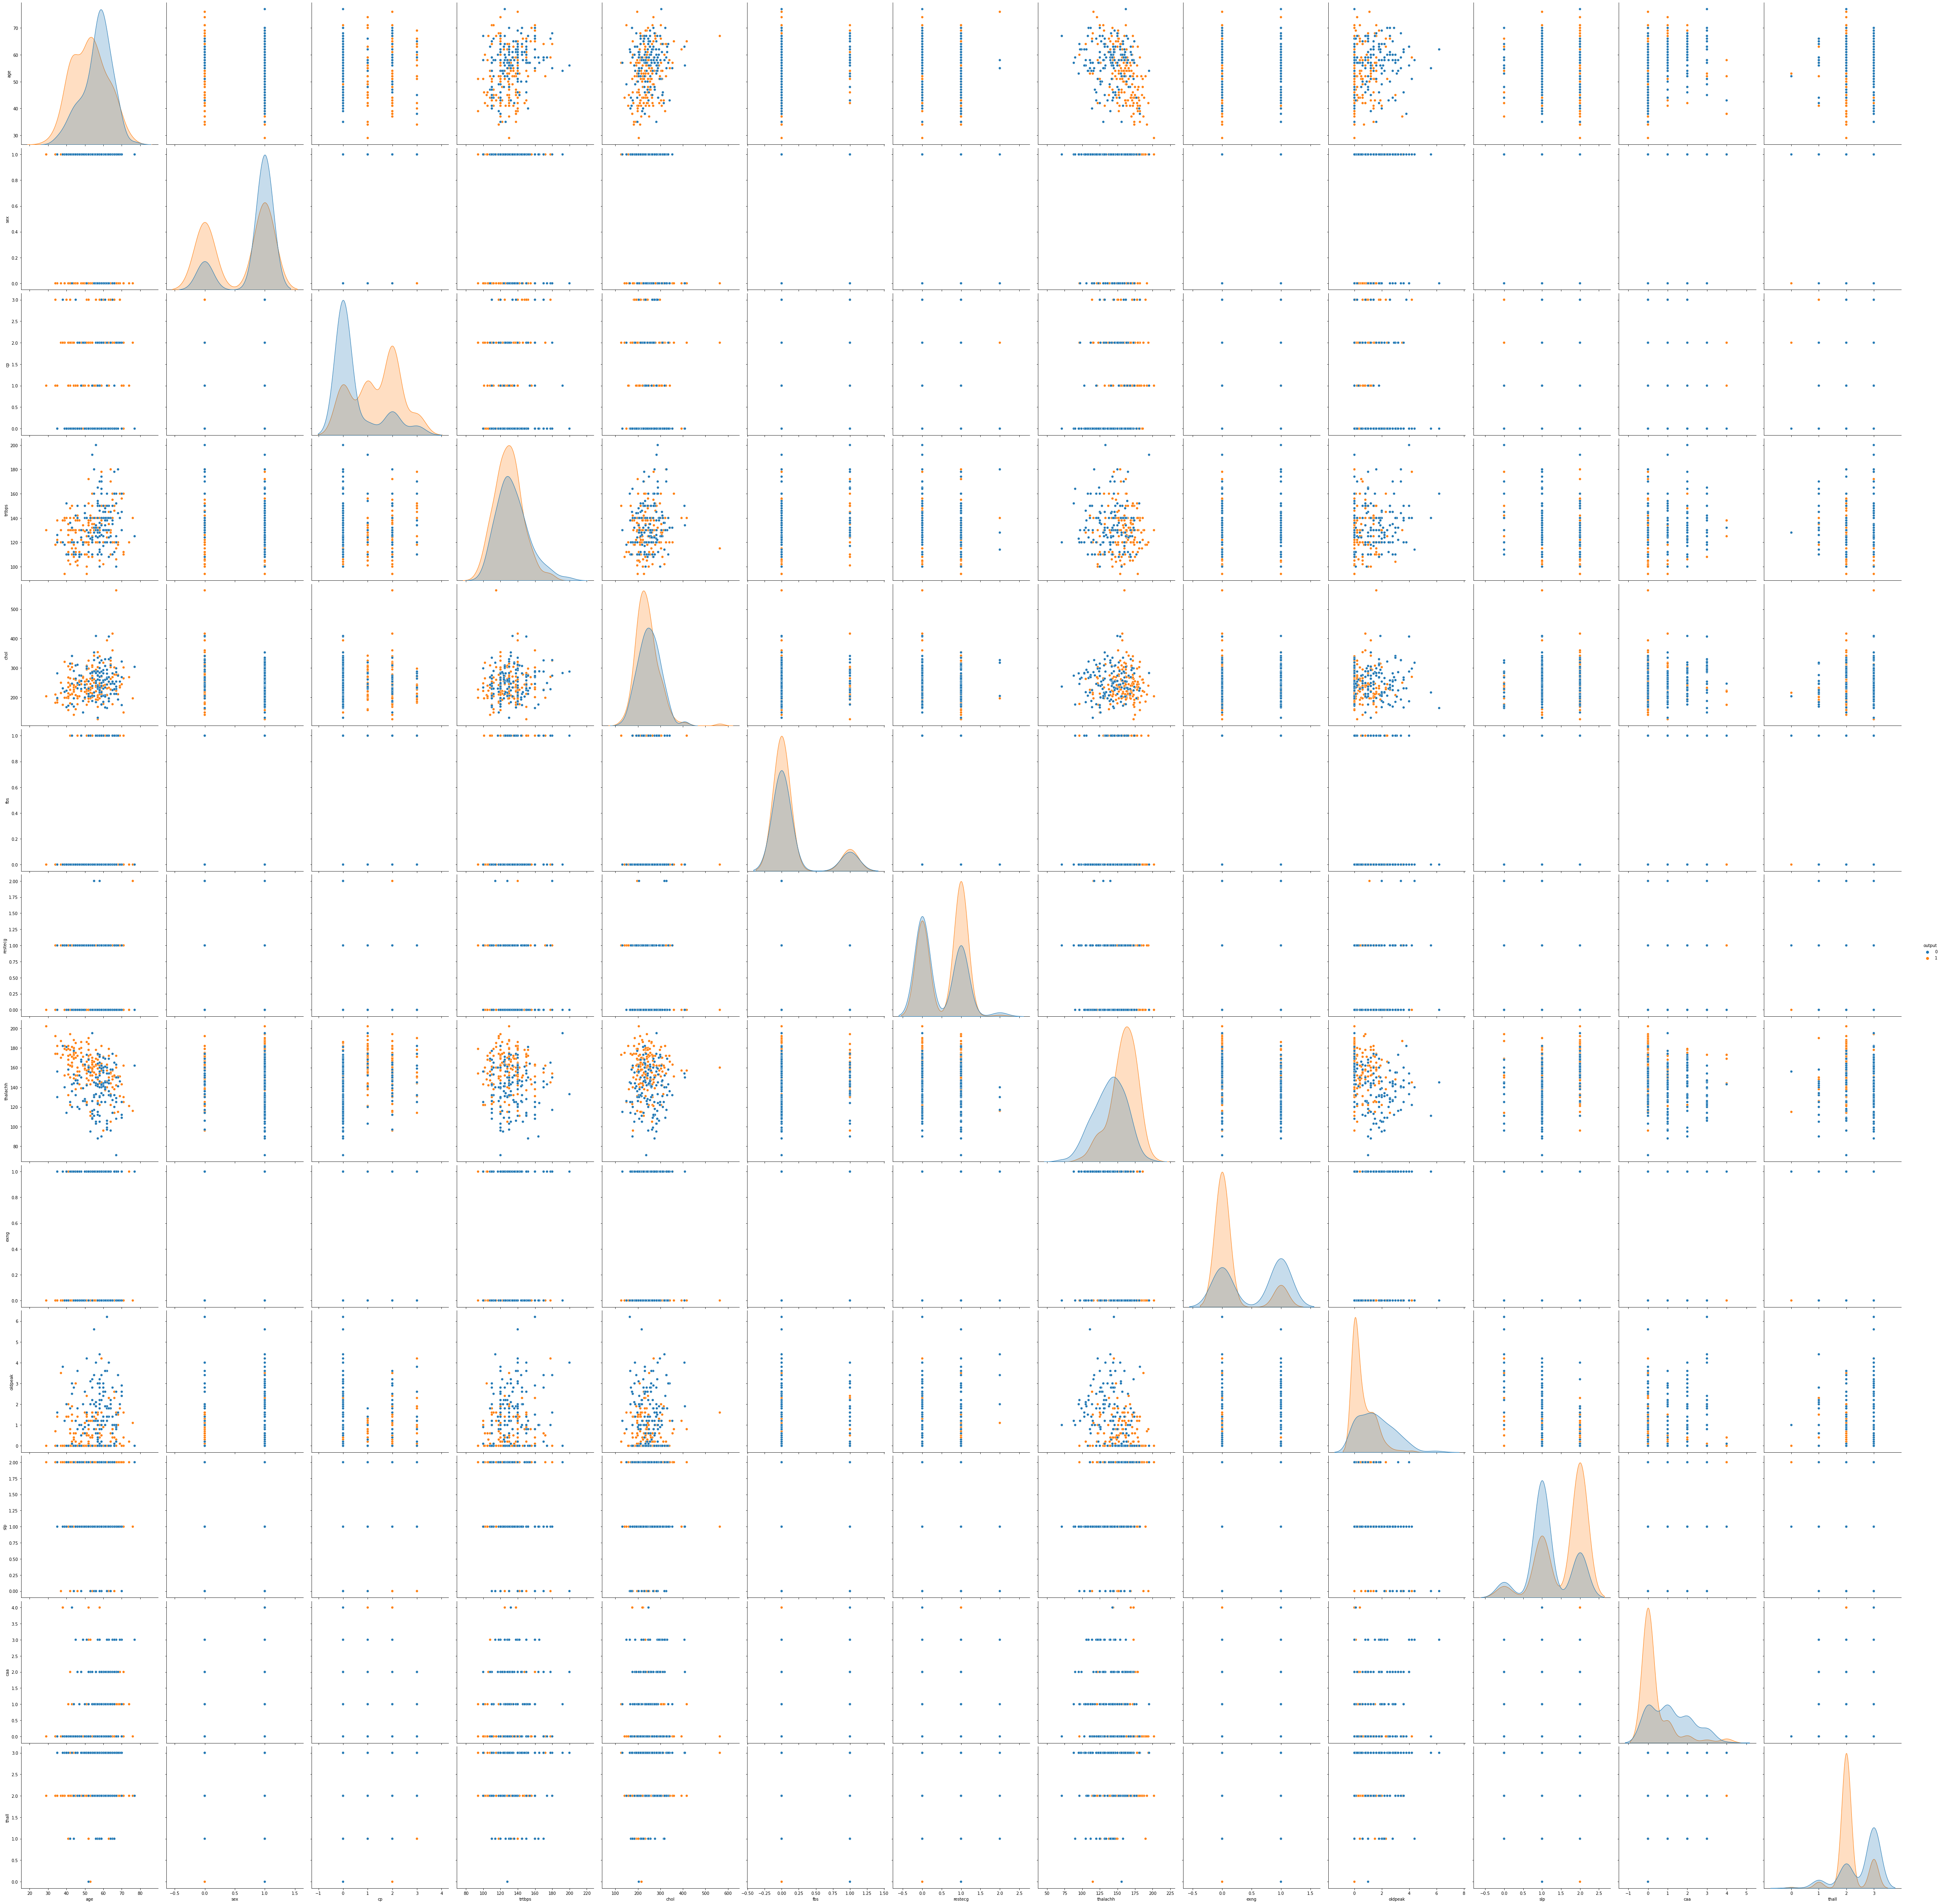

In [48]:
#display pair plot for multivariate feature analysis of the dataset
NrOfCols = getDatasetDimensionality(df_originalDataset)+1
#print(NrOfCols)
className = df_originalDataset.columns[NrOfCols-1]
#print(className)
displayMultivariateAnalysisPlot(df_originalDataset, className, 5)

In [49]:
#seperating independant and depandant variables (features and labels)
df_X = df_originalDataset.drop(className,axis=1)
df_Y = df_originalDataset[className]
print (df_X)
print (df_Y)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  
0      0      1  
1      0      2

In [50]:
#split the featues and labels into train and test data
[df_X_train, df_X_test, df_Y_train, df_Y_test] = getSplitTrainNtestDataUsingStratKfold(df_X, df_Y, stratifiedKfoldSplits)
print(df_X_train)
print(df_X_test)
print(df_Y_train)
print(df_Y_train)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
5     57    1   0     140   192    0        1       148     0      0.4    1   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
297   59    1   0     164   176    1        0        90     0      1.0    1   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  
0      0      1  
1      0      2

In [51]:
#performing PCA to reduce dimensionality
#TBD; required ?

In [52]:
#generate the Random Forest model using the train data
RFmodel = getRandomForestModelForDataset(df_X_train, df_Y_train, estimators4RandomForest)
RFmodel

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)

In [53]:
#get the predicted values for the test inputs/features and its accuracy
[df_Y_predicted, ModelAccuracyInPercentage] = getPredictedValuesNaccuracy(RFmodel, df_X_test, df_Y_test)
print("Predicted values = ", df_Y_predicted)
print ("Accuracy of predicted values = ", ModelAccuracyInPercentage)

Predicted values =  [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0]
Accuracy of predicted values =  83.33333333333334


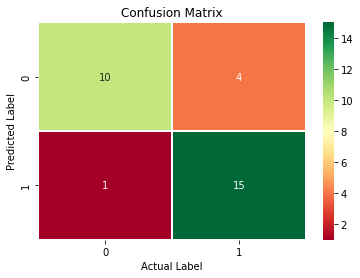

In [54]:
#plot confusion matrix for analysing the prediction
displayConfusionMatrixHeatMap(df_Y_test, df_Y_predicted)


In [55]:
# get the classification report for the prediction
displayClassificationReport(df_Y_test, df_Y_predicted)

precision    recall  f1-score    support
1              0.789474  0.937500  0.857143  16.000000
accuracy       0.833333  0.833333  0.833333   0.833333
weighted avg   0.845295  0.833333  0.830476  30.000000
macro avg      0.849282  0.825893  0.828571  30.000000
0              0.909091  0.714286  0.800000  14.000000

In [56]:
#get the input features for the train and test data for class'0'
[X_train_class0, X_test_class0] = getTrainNtestFeatures4APredictedLabel(df_X_train, df_X_test, df_Y_train, df_Y_predicted, 0)
print (X_train_class0)
print (X_test_class0)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
165   67    1   0     160   286    0        0       108     1      1.5    1   
166   67    1   0     120   229    0        0       129     1      2.6    1   
167   62    0   0     140   268    0        0       160     0      3.6    0   
168   63    1   0     130   254    0        0       147     0      1.4    1   
169   53    1   0     140   203    1        0       155     1      3.1    0   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
297   59    1   0     164   176    1        0        90     0      1.0    1   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  
165    3      2  
166    2      3

In [57]:
#get the input features for the train and test data for class'1'
[X_train_class1, X_test_class1] = getTrainNtestFeatures4APredictedLabel(df_X_train, df_X_test, df_Y_train, df_Y_predicted, 1)
print (X_train_class1)
print (X_test_class1)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
5     57    1   0     140   192    0        1       148     0      0.4    1   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
160   56    1   1     120   240    0        1       169     0      0.0    0   
161   55    0   1     132   342    0        1       166     0      1.2    2   
162   41    1   1     120   157    0        1       182     0      0.0    2   
163   38    1   2     138   175    0        1       173     0      0.0    2   
164   38    1   2     138   175    0        1       173     0      0.0    2   

     caa  thall  
0      0      1  
1      0      2

In [58]:
#find all the distance measures for features of class'0'
getAllStatDistMeasureForAclassTrainNtestInputs(X_train_class0, X_test_class0)

Feature  Anderson_Darling        CVM        DTS  Kolmogorov_Smirnov  \
0        age          0.701637   2.720674   0.724618            0.189150   
1        sex          0.000990   0.004399   0.000990            0.004399   
2         cp          0.072621   0.293988   0.072621            0.151026   
3     trtbps          0.542892   2.465543   1.298471            0.208944   
4       chol          2.731111  11.810850   9.461919            0.301320   
5        fbs          0.048168   0.210411   0.048168            0.210411   
6    restecg          0.018842   0.051320   0.018842            0.027126   
7   thalachh          1.305987   5.887097   1.886580            0.231672   
8       exng          0.004716   0.027126   0.004716            0.027126   
9    oldpeak          0.674371   3.146628   0.108238            0.265396   
10       slp          0.036764   0.131965   0.036764            0.101173   
11       caa          0.035563   0.178886   0.035563            0.099707   
12     thall          0.072690   0.302053   0.072690            0.189150   
13    SUM =>          6.246354  27.230938  13.770182            2.006598   

      Kuiper  Wasserstein  
0   0.193548     2.752933  
1   0.004399     0.004399  
2   0.151026     0.293988  
3   0.271261     4.944282  
4   0.362170    28.166422  
5   0.210411     0.210411  
6   0.051320     0.051320  
7   0.410557     7.493402  
8   0.027126     0.027126  
9   0.362170     0.449853  
10  0.131965     0.131965  
11  0.145894     0.178886  
12  0.189150     0.302053  
13  2.510997    45.007038

In [59]:
#find all the distance measures for features of class'1'
getAllStatDistMeasureForAclassTrainNtestInputs(X_train_class1, X_test_class1)

Feature  Anderson_Darling        CVM       DTS  Kolmogorov_Smirnov  \
0        age          0.462631   1.964324  0.534693            0.157542   
1        sex          0.007930   0.050865  0.007930            0.050865   
2         cp          0.068918   0.401272  0.068918            0.202402   
3     trtbps          0.381191   1.565171  0.845044            0.106676   
4       chol          1.982129   9.027905  6.292920            0.221123   
5        fbs          0.006947   0.030378  0.006947            0.030378   
6    restecg          0.027086   0.173084  0.027086            0.173084   
7   thalachh          0.866797   3.987284  1.265723            0.207700   
8       exng          0.033768   0.147651  0.033768            0.147651   
9    oldpeak          0.247846   1.050512  0.037069            0.104203   
10       slp          0.006814   0.040975  0.006814            0.039915   
11       caa          0.090087   0.377605  0.090087            0.279053   
12     thall          0.032128   0.089721  0.032128            0.046980   
13    SUM =>          4.214272  18.906747  9.249128            1.767573   

      Kuiper  Wasserstein  
0   0.292829     2.108442  
1   0.050865     0.050865  
2   0.202402     0.401272  
3   0.133522     3.078418  
4   0.330978    18.731544  
5   0.030378     0.030378  
6   0.173084     0.173084  
7   0.388909     5.181561  
8   0.147651     0.147651  
9   0.124338     0.130590  
10  0.039915     0.040975  
11  0.326033     0.377605  
12  0.046980     0.089721  
13  2.287884    30.542105

In [60]:
#find all the distance measures for feature and accuracies of class '0' for all K-folds train and test sets
df_DistsNAccuraciesClass0 = getAccuracyNdistMeasures4allFolds(df_originalDataset, className, 0)
df_DistsNAccuraciesClass0

Anderson_Darling        CVM        DTS  Kolmogorov_Smirnov    Kuiper  \
0          5.063261  20.478495   8.305047            2.182796  2.948925   
1          6.194797  27.639785  10.643803            1.971505  2.505376   
2          5.783692  26.096041   8.454502            2.431085  2.905425   
3          6.258563  29.273333  11.780864            2.387111  2.739111   
4          4.131000  17.236000   7.878551            1.932000  2.528000   
5          7.449873  33.172581  13.601346            2.662903  2.988710   
6          4.258708  19.370968   7.560076            1.565939  2.061670   
7          5.262527  23.288710  12.509020            2.162903  2.798387   
8          5.166435  22.906452   8.757379            2.111290  2.508065   
9          6.246354  27.230938  13.770182            2.006598  2.510997   

   Wasserstein   Accuracy  
0    28.659140  87.096774  
1    41.216452  83.870968  
2    31.628666  83.870968  
3    44.750356  76.666667  
4    27.095600  90.000000  
5    52.045484  80.000000  
6    27.939137  83.333333  
7    39.310161  73.333333  
8    32.733763  83.333333  
9    45.007038  83.333333

In [61]:
#find all the distance measures for feature and accuracies of class '1' for all K-folds train and test sets
df_DistsNAccuraciesClass1 = getAccuracyNdistMeasures4allFolds(df_originalDataset, className, 1)
df_DistsNAccuraciesClass1

Anderson_Darling        CVM        DTS  Kolmogorov_Smirnov    Kuiper  \
0          4.003801  17.314723   7.889178            1.805477  2.147937   
1          5.370341  25.369932   9.215700            1.734797  2.204392   
2          4.193888  19.339189   7.492379            1.744595  2.160811   
3          5.487455  26.137387   9.494756            1.594595  2.042793   
4          4.390467  19.960811  10.530524            1.454054  1.805405   
5          3.845434  17.766779   8.935526            1.557383  2.038255   
6          5.798499  25.906557  10.046824            1.780589  2.247290   
7          4.360006  20.656040   8.266050            1.534899  2.137919   
8          5.408739  23.669351  10.447438            1.805369  2.250559   
9          4.214272  18.906747   9.249128            1.767573  2.287884   

   Wasserstein   Accuracy  
0    27.911629  87.096774  
1    36.101520  83.870968  
2    27.830946  83.870968  
3    38.468468  76.666667  
4    34.877568  90.000000  
5    28.057282  80.000000  
6    38.613526  83.333333  
7    31.569060  73.333333  
8    37.014049  83.333333  
9    30.542105  83.333333

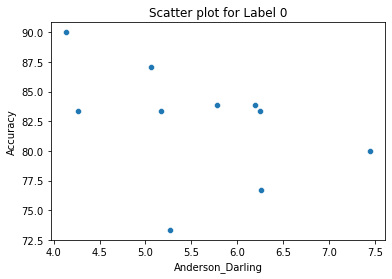

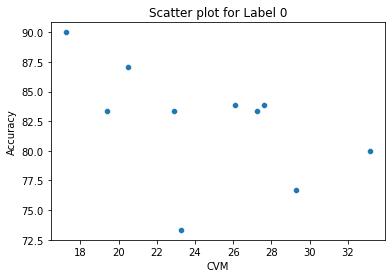

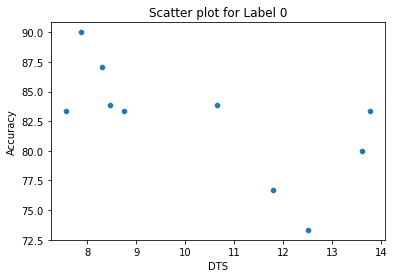

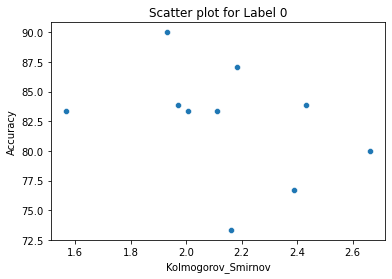

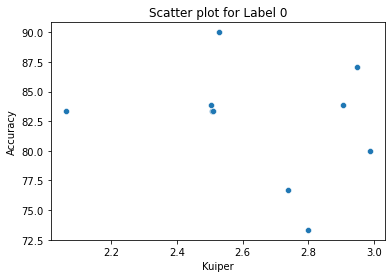

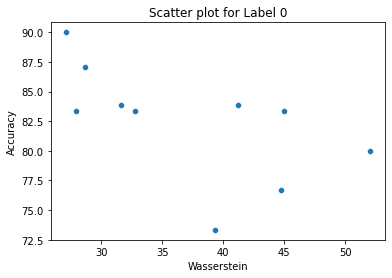

In [62]:
#scatter plot for all the distance measures and accuracies for class0
displayScatterPlot4AllDistsNAccuracies(df_DistsNAccuraciesClass0, "0")

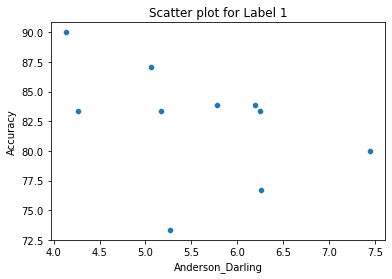

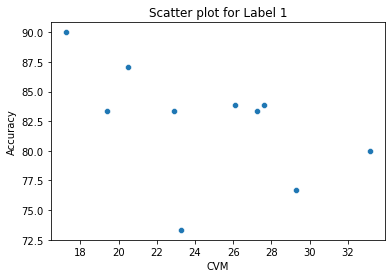

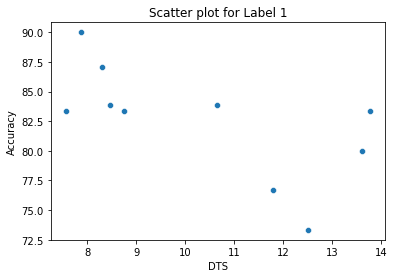

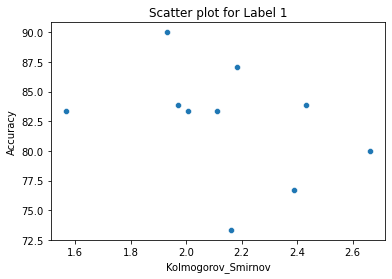

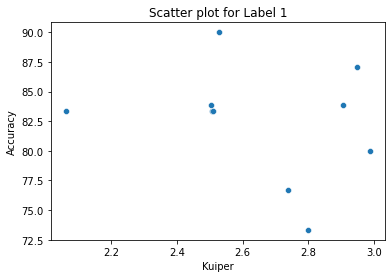

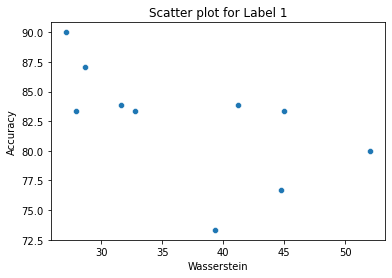

In [63]:
#scatter plot for all the distance measures and accuracies for class1
displayScatterPlot4AllDistsNAccuracies(df_DistsNAccuraciesClass0, "1")

In [64]:
#find pearson correlation values between accuracies and distance measures for class 0
df_corrDistNAccrClass0 = getPearsonCorrValues4allDistsNAccuracies(df_DistsNAccuraciesClass0)
df_corrDistNAccrClass0

Anderson_Darling       CVM       DTS  Kolmogorov_Smirnov   Kuiper  \
0         -0.428632 -0.510051 -0.639224           -0.360767 -0.23225   

   Wasserstein  
0    -0.596856

In [65]:
#find pearson correlation values between accuracies and distance measures for class 1
df_corrDistNAccrClass1 = getPearsonCorrValues4allDistsNAccuracies(df_DistsNAccuraciesClass1)
df_corrDistNAccrClass1

Anderson_Darling       CVM       DTS  Kolmogorov_Smirnov    Kuiper  \
0         -0.113221 -0.236077  0.243415            0.257691 -0.197552   

   Wasserstein  
0    -0.065869

In [66]:
#finding the best distance measure and value
lst_df_corrDistNAccrClass = []
lst_df_corrDistNAccrClass.append(df_corrDistNAccrClass0)
lst_df_corrDistNAccrClass.append(df_corrDistNAccrClass1)
lst_BestDistMeasure = getBestDistanceMeasureForDataset(lst_df_corrDistNAccrClass, method='min_mean')#min, min_mean, max_mean, max
print(lst_BestDistMeasure)

['Kuiper', 0.21490073459434494, 'min_mean']


In [67]:
#dataset characteristics calculations in a table
df_datasetChara = getAllDatasetCharacteristicsTable(df_originalDataset, className)
df_datasetChara

Parameters       Value
0                               Dimensionality (d)          13
1                                NrOfInstances (N)         303
2                                  NrOfClasses (C)           2
3                                ZeroSparsity (OS)     0.19345
4                                 NaNSparsity (NS)         0.0
5                                DataSparsity (DS)    1.054766
6                          DataSparsityRatio (DSR)         TBD
7       Correlation of Featues with Class (CorrFC)    0.107005
8   Correlation of Featues without Class (CorrFNC)    0.135195
9                    Multivariate normality? (MVN)       False
10         Homogeneity of class covariance (HCCov)         1.0
11               Intrinsic Dimensionality-PCA (ID)           3
12            Intrinsic Dimensionality Ratio (IDR)    0.230769
13                    Feature Noise variance (FN1)  277.399924
14                       Feature Noise paper (FN2)    0.769231

In [68]:
#combining the table with the best distance measures values
df_finalTable = df_datasetChara.append({'Parameters' : 'Distance Measure (min_mean)', 'Value':lst_BestDistMeasure[0]}, 
                ignore_index = True)
df_finalTable

Parameters       Value
0                               Dimensionality (d)          13
1                                NrOfInstances (N)         303
2                                  NrOfClasses (C)           2
3                                ZeroSparsity (OS)     0.19345
4                                 NaNSparsity (NS)         0.0
5                                DataSparsity (DS)    1.054766
6                          DataSparsityRatio (DSR)         TBD
7       Correlation of Featues with Class (CorrFC)    0.107005
8   Correlation of Featues without Class (CorrFNC)    0.135195
9                    Multivariate normality? (MVN)       False
10         Homogeneity of class covariance (HCCov)         1.0
11               Intrinsic Dimensionality-PCA (ID)           3
12            Intrinsic Dimensionality Ratio (IDR)    0.230769
13                    Feature Noise variance (FN1)  277.399924
14                       Feature Noise paper (FN2)    0.769231
15                     Distance Measure (min_mean)      Kuiper

In [69]:
#Populate the table for dataset characteristics and best distance measure for all the datasets in the folder (small sized files)
datasetsPath = './Datasets/FinalDatasets/SmallFiles/'
df_finalTableSmall = populateDatasetCharaNdistMeasureTable(datasetsPath)
df_finalTableSmall

Parameters  Dimensionality (d)  NrOfInstances (N)  NrOfClasses (C)  \
0                           10               1715                2   
1                            4                625                3   
2                            3                400                2   
3                            3                500                6   
4                            9                683                2   
..                         ...                ...              ...   
70                           7                712                2   
71                           4                748                2   
72                          12               5000                2   
73                          11               1599                2   
74                          13                178                3   

Parameters  ZeroSparsity (OS)  NaNSparsity (NS)  DataSparsity (DS)  \
0                    0.044431               0.0           1.071773   
1                    0.304800               0.0           1.316074   
2                    0.635000               0.0           1.259921   
3                    0.508000               0.0           1.817121   
4                    0.123963               0.0           1.080060   
..                        ...               ...                ...   
70                   0.152889               0.0           1.104090   
71                   0.254679               0.0           1.189207   
72                   0.012700               0.0           1.059463   
73                   0.043323               0.0           1.065041   
74                   0.329300               0.0           1.088182   

Parameters DataSparsityRatio (DSR)  \
0                              TBD   
1                              TBD   
2                              TBD   
3                              TBD   
4                              TBD   
..                             ...   
70                             TBD   
71                             TBD   
72                             TBD   
73                             TBD   
74                             TBD   

Parameters  Correlation of Featues with Class (CorrFC)  \
0                                             0.246832   
1                                             0.236134   
2                                             0.143226   
3                                             0.314941   
4                                             0.222884   
..                                                 ...   
70                                            0.174773   
71                                            0.472525   
72                                            0.093543   
73                                            0.205264   
74                                            0.206138   

Parameters  Correlation of Featues without Class (CorrFNC)  \
0                                             2.225539e-01   
1                                             4.693135e-16   
2                                             1.883912e-01   
3                                             9.215258e-03   
4                                             6.019393e-01   
..                                                     ...   
70                                            1.823212e-01   
71                                            4.659983e-01   
72                                            8.867212e-02   
73                                            1.998232e-01   
74                                            3.049575e-01   

Parameters  Multivariate normality? (MVN)  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   
..                                    ...   
70                                  False   
71                                  False   
72            

In [70]:
#save the table to the csv file
saveDataframeToCSV(df_finalTableSmall, './Datasets/FinalDatasets/consolidatedTableSmall.csv')
#saveDataframeToCSV(df_finalTableBig, datasetsPath+'/consolidatedTable.csv')

In [71]:
#Populate the table for dataset characteristics and best distance measure for all the datasets in the folder (medium sized files)
datasetsPath = './Datasets/FinalDatasets/MediumFiles/'
df_finalTableMedium = populateDatasetCharaNdistMeasureTable(datasetsPath)
df_finalTableMedium

Parameters  Dimensionality (d)  NrOfInstances (N)  NrOfClasses (C)  \
0                            7              30477                2   
1                           16              11162                2   
2                           17               5000                2   
3                           10              10000                2   
4                           10              10999                2   
5                            9              14999                3   
6                           12               2500                2   
7                            9              10000                9   
8                           17               3333                2   
9                           27               5789                2   
10                          20               3879                2   
11                           6               3644                3   
12                         531                373                2   
13                          19               7011                2   

Parameters  ZeroSparsity (OS)  NaNSparsity (NS)  DataSparsity (DS)  \
0                    0.003572               0.0           1.104090   
1                    0.004267               0.0           1.044274   
2                    0.008965               0.0           1.041616   
3                    0.007620               0.0           1.071773   
4                    0.006928               0.0           1.071773   
5                    0.005645               0.0           1.129831   
6                    0.025400               0.0           1.059463   
7                    0.008467               0.0           1.276518   
8                    0.013448               0.0           1.041616   
9                    0.004875               0.0           1.026004   
10                   0.009822               0.0           1.035265   
11                   0.034852               0.0           1.200937   
12                   0.003847               0.0           1.001306   
13                   0.005720               0.0           1.037155   

Parameters DataSparsityRatio (DSR)  \
0                              TBD   
1                              TBD   
2                              TBD   
3                              TBD   
4                              TBD   
5                              TBD   
6                              TBD   
7                              TBD   
8                              TBD   
9                              TBD   
10                             TBD   
11                             TBD   
12                             TBD   
13                             TBD   

Parameters  Correlation of Featues with Class (CorrFC)  \
0                                             0.067105   
1                                             0.067570   
2                                             0.079642   
3                                             0.023557   
4                                             0.053942   
5                                             0.083674   
6                                             0.417132   
7                                             0.041794   
8                                             0.082369   
9                                             0.057637   
10                                            0.123956   
11                                            0.109612   
12                                            0.177921   
13                                            0.217319   

Parameters  Correlation of Featues without Class (CorrFNC)  \
0                                                 0.047359   
1                                                 0.061848   
2                                                 0.045691   
3                                                 0.021342   
4                                                 0.053298   
5                                                 0.087635   
6                     

In [72]:
#save the table to the csv file
saveDataframeToCSV(df_finalTableMedium, './Datasets/FinalDatasets/consolidatedTableMedium.csv')

In [73]:
#Populate the table for dataset characteristics and best distance measure for all the datasets in the folder (medium sized files)
datasetsPath = './Datasets/FinalDatasets/BigFiles/'
df_finalTableBig = populateDatasetCharaNdistMeasureTable(datasetsPath)
df_finalTableBig

Parameters  Dimensionality (d)  NrOfInstances (N)  NrOfClasses (C)  \
0                           11              13393                4   
1                         7465                 36                2   
2                            6              12001                2   
3                           14              14980                2   
4                           28              14093                2   
5                           16              24803                2   
6                           10              18185                2   
7                           12              23548                2   
8                           10              10000                4   
9                         1558                343                2   
10                          20               7996                2   

Parameters  ZeroSparsity (OS)  NaNSparsity (NS)  DataSparsity (DS)  \
0                    0.005172               0.0           1.134313   
1                    0.002835               0.0           1.000093   
2                    0.010582               0.0           1.122462   
3                    0.003633               0.0           1.050757   
4                    0.001931               0.0           1.025064   
5                    0.001920               0.0           1.044274   
6                    0.004190               0.0           1.071773   
7                    0.002697               0.0           1.059463   
8                    0.007620               0.0           1.148698   
9                    0.001426               0.0           1.000445   
10                   0.004765               0.0           1.035265   

Parameters DataSparsityRatio (DSR)  \
0                              TBD   
1                              TBD   
2                              TBD   
3                              TBD   
4                              TBD   
5                              TBD   
6                              TBD   
7                              TBD   
8                              TBD   
9                              TBD   
10                             TBD   

Parameters  Correlation of Featues with Class (CorrFC)  \
0                                             0.379310   
1                                             0.227971   
2                                             0.426905   
3                                             0.437240   
4                                             0.247173   
5                                             0.350048   
6                                             0.494494   
7                                             0.143895   
8                                             0.111264   
9                                             0.033202   
10                                            0.109310   

Parameters  Correlation of Featues without Class (CorrFNC)  \
0                                                 0.351050   
1                                                 0.174053   
2                                                 0.217682   
3                                                 0.306039   
4                                                 0.228342   
5                                                 0.351236   
6                                                 0.582490   
7                                                 0.143997   
8                                                 0.076436   
9                                                 0.018641   
10                                                0.108494   

Parameters  Multivariate normality? (MVN)  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   
5                                   False   
6                                   False   
7                                   False   
8             

In [74]:
#save the table to the csv file
saveDataframeToCSV(df_finalTableBig, './Datasets/FinalDatasets/consolidatedTableBig.csv')

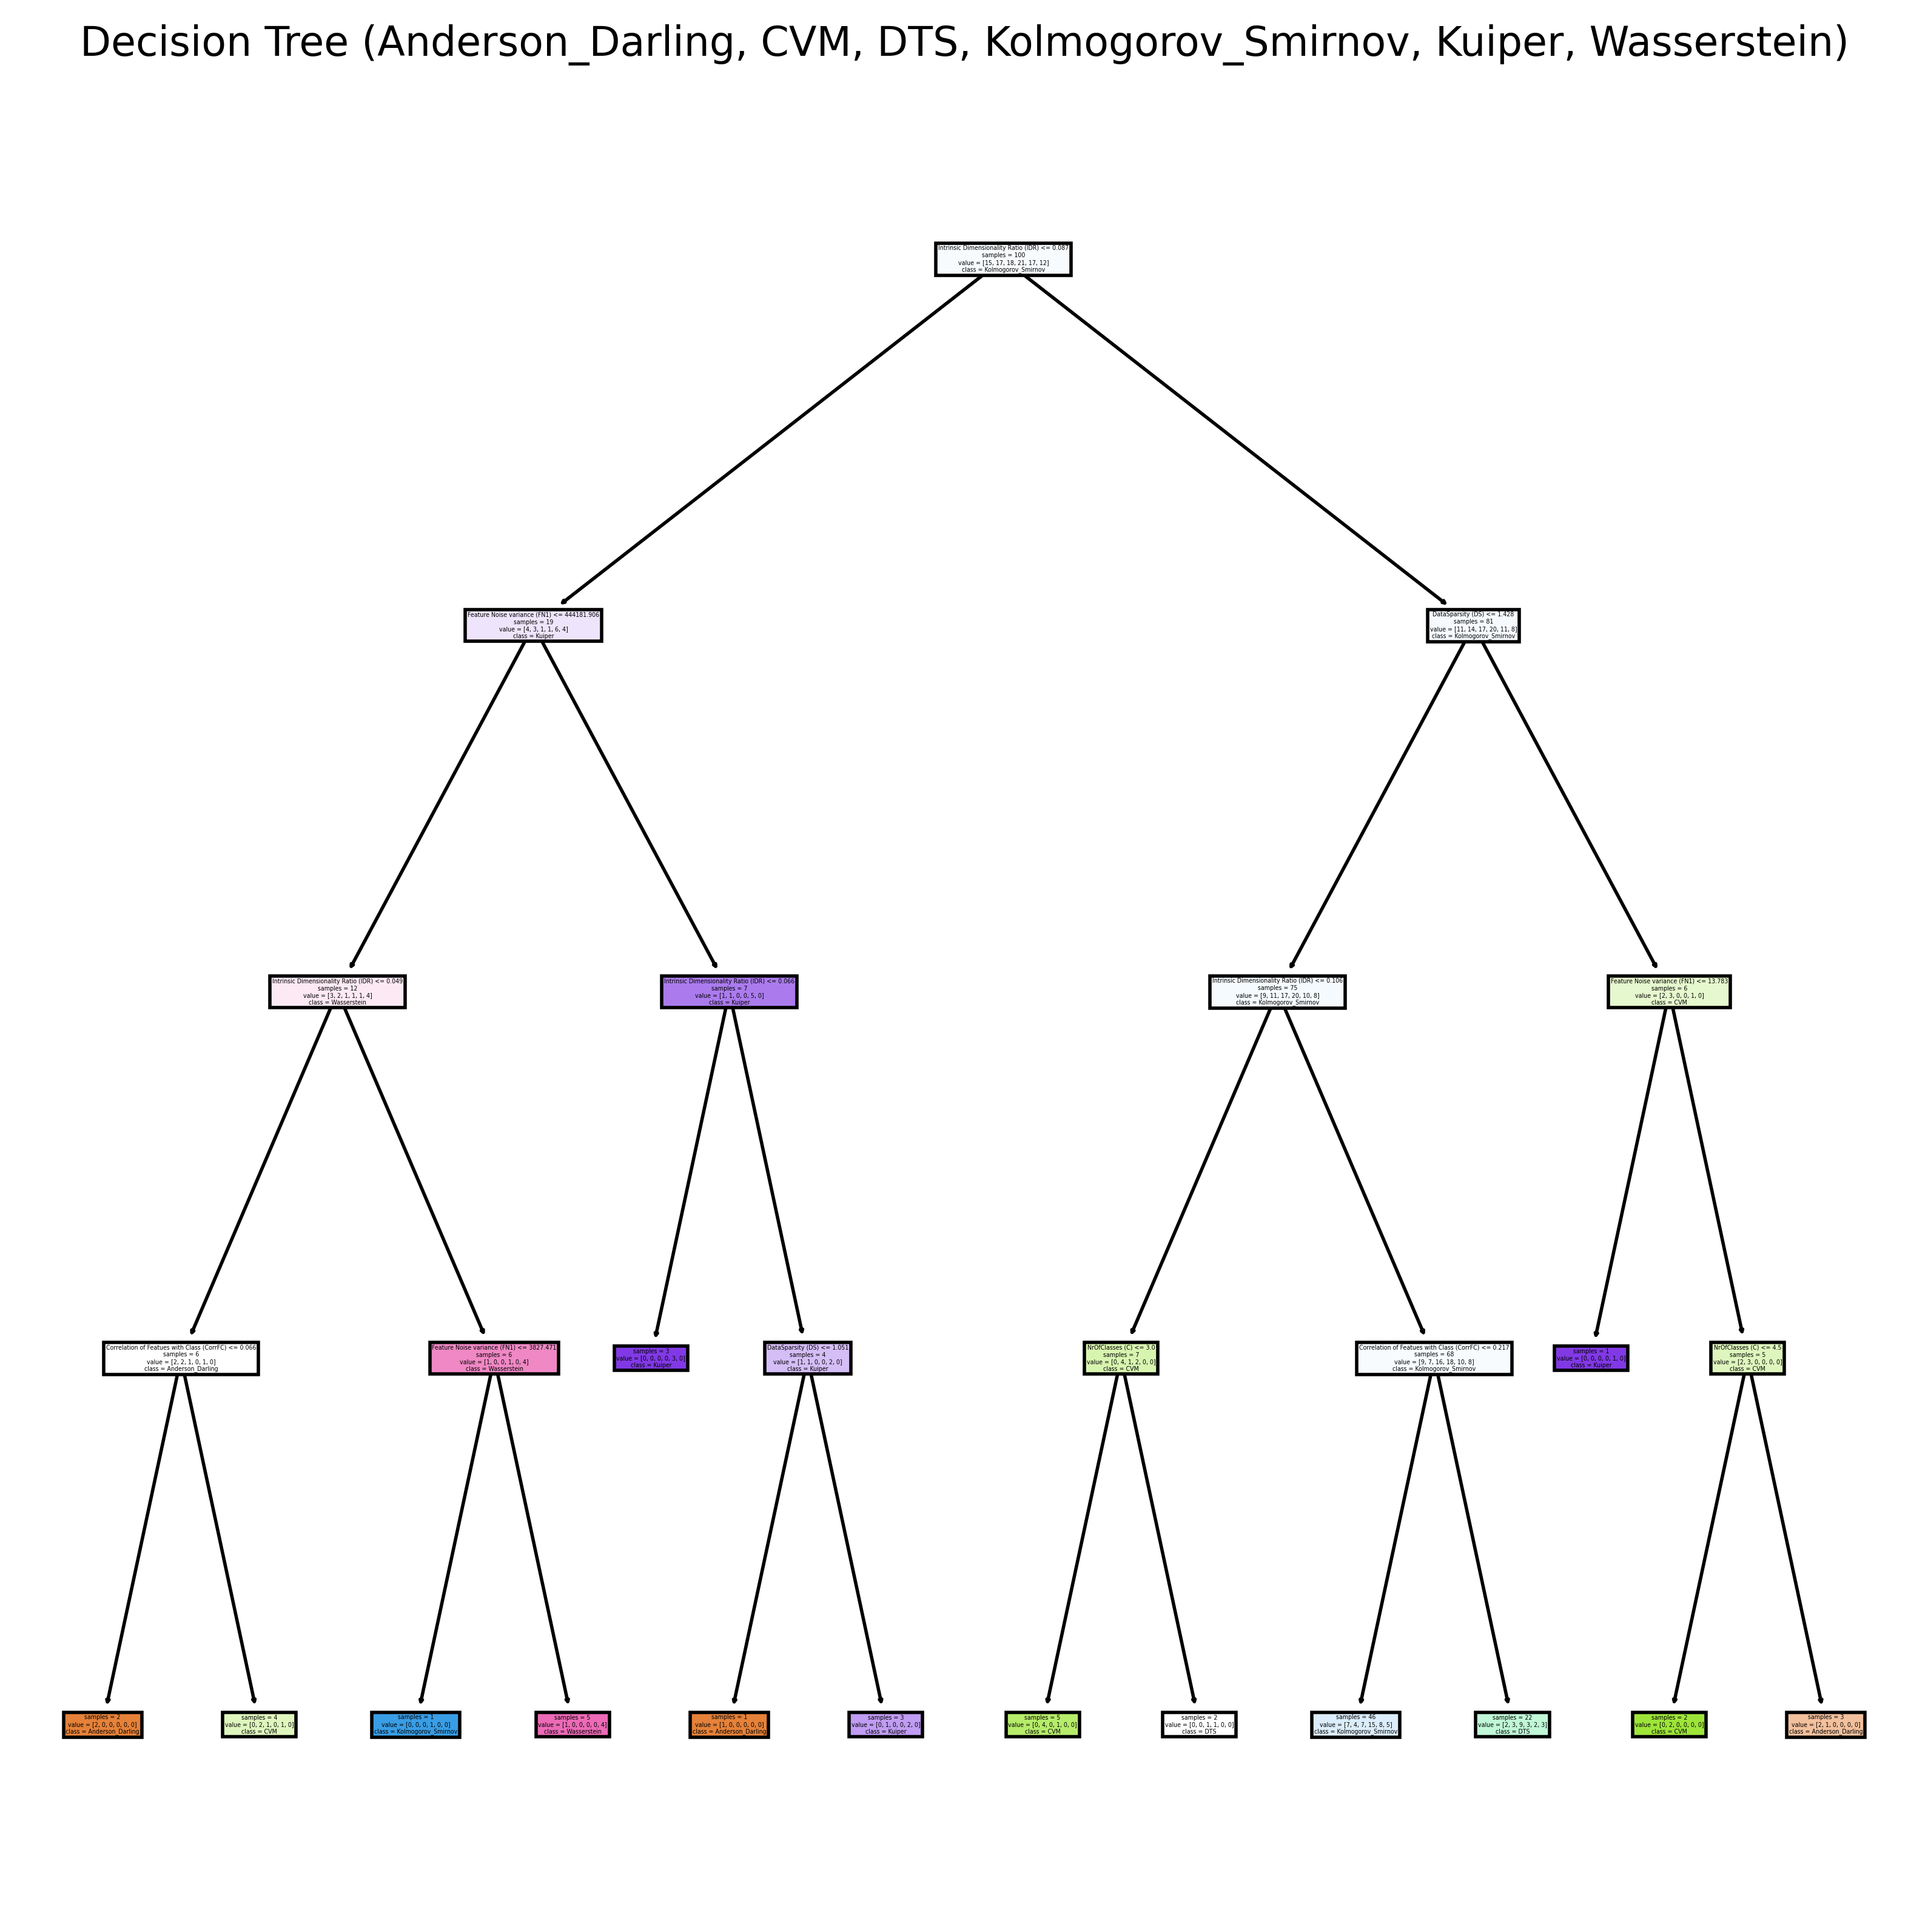

In [75]:
#Plot the decision tree to analyse the results
df_Results = readDataset2DataFrame('./Datasets/FinalDatasets/FinalResult/consolidatedResults00.csv')
#df_Results.head()
drawNSaveDecisionTree(df_Results, 'Distance Measure (min_mean)', 'Result_DecisionTree00.png')